Firstly, we need to import all necessary libraries.


#Necessary imports



In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'google'

Then, we load the file

#Code itself

In [4]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/Credit_card.csv")
labels  = pd.read_csv("drive/MyDrive/Colab Notebooks/Credit_card_label.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/Credit_card.csv'

And check the first 5 rows

In [4]:
df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


In [5]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Ind_ID,1548.0,5.078920e+06,41717.587742,5008827.0,5045069.75,5078841.5,5115673.00,5150412.0
CHILDREN,1548.0,4.127907e-01,0.776691,0.0,0.00,0.0,1.00,14.0
Annual_income,1525.0,1.913993e+05,113252.997656,33750.0,121500.00,166500.0,225000.00,1575000.0
Birthday_count,1526.0,-1.604034e+04,4229.503202,-24946.0,-19553.00,-15661.5,-12417.00,-7705.0
Employed_days,1548.0,5.936469e+04,137808.062701,-14887.0,-3174.50,-1565.0,-431.75,365243.0
Mobile_phone,1548.0,1.000000e+00,0.000000,1.0,1.00,1.0,1.00,1.0
Work_Phone,1548.0,2.080103e-01,0.406015,0.0,0.00,0.0,0.00,1.0
Phone,1548.0,3.094315e-01,0.462409,0.0,0.00,0.0,1.00,1.0
EMAIL_ID,1548.0,9.237726e-02,0.289651,0.0,0.00,0.0,0.00,1.0
Family_Members,1548.0,2.161499e+00,0.947772,1.0,2.00,2.0,3.00,15.0


In [2]:
df_corr = df.corr()
df_corr


NameError: name 'df' is not defined

We can see NaN values, we need to examine the total amount and how it can impact our analysis

In [6]:
df.isna().sum()

Ind_ID               0
GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Mobile_phone         0
Work_Phone           0
Phone                0
EMAIL_ID             0
Type_Occupation    488
Family_Members       0
dtype: int64

There is a lot of NaN values in Type_Occupation column. We can see how much of an impact it has on our dataset by checking the total sum of all records.

In [7]:
df.count()

Ind_ID             1548
GENDER             1541
Car_Owner          1548
Propert_Owner      1548
CHILDREN           1548
Annual_income      1525
Type_Income        1548
EDUCATION          1548
Marital_status     1548
Housing_type       1548
Birthday_count     1526
Employed_days      1548
Mobile_phone       1548
Work_Phone         1548
Phone              1548
EMAIL_ID           1548
Type_Occupation    1060
Family_Members     1548
dtype: int64

In [8]:
print(488/1548)

0.3152454780361757


We can see that almost 31 % valus are missing, meaning we should take care of it. According to dataset description, column "Type_Occupation" refers to Occupation, meaning the job person is doing. We can make several approaches and then check, which performed best.


For now, we will just ignore NaN values and drop them out of df.

##Ignoring the NA's



```



In [9]:
df_dummies =pd.get_dummies(df)
df_dummies

,Ind_ID,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,...,Type_Occupation_Laborers,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff
0,5008827,0,180000.0,-18772.0,365243,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,5009744,0,315000.0,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
2,5009746,0,315000.0,NaN,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
3,5009749,0,NaN,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
4,5009752,0,315000.0,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,0,NaN,-11957.0,-2182,1,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0
1544,5023655,0,225000.0,-10229.0,-1209,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1545,5115992,2,180000.0,-13174.0,-2477,1,0,0,0,4,...,0,0,1,0,0,0,0,0,0,0
1546,5118219,0,270000.0,-15292.0,-645,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df2 = df.copy()

In [11]:
df.dropna(inplace = True)

In [12]:
df.isna().sum()

Ind_ID             0
GENDER             0
Car_Owner          0
Propert_Owner      0
CHILDREN           0
Annual_income      0
Type_Income        0
EDUCATION          0
Marital_status     0
Housing_type       0
Birthday_count     0
Employed_days      0
Mobile_phone       0
Work_Phone         0
Phone              0
EMAIL_ID           0
Type_Occupation    0
Family_Members     0
dtype: int64

Now, we can proceed with further analysis for this case. We can check the distrubutions of quantitive data

In [13]:
df_binary = df[['Phone','Work_Phone']].copy()
df_binary

,Phone,Work_Phone
8,1,0
9,1,0
10,1,0
11,1,1
13,1,1
...,...,...
1540,0,0
1542,1,0
1544,0,0
1545,0,0


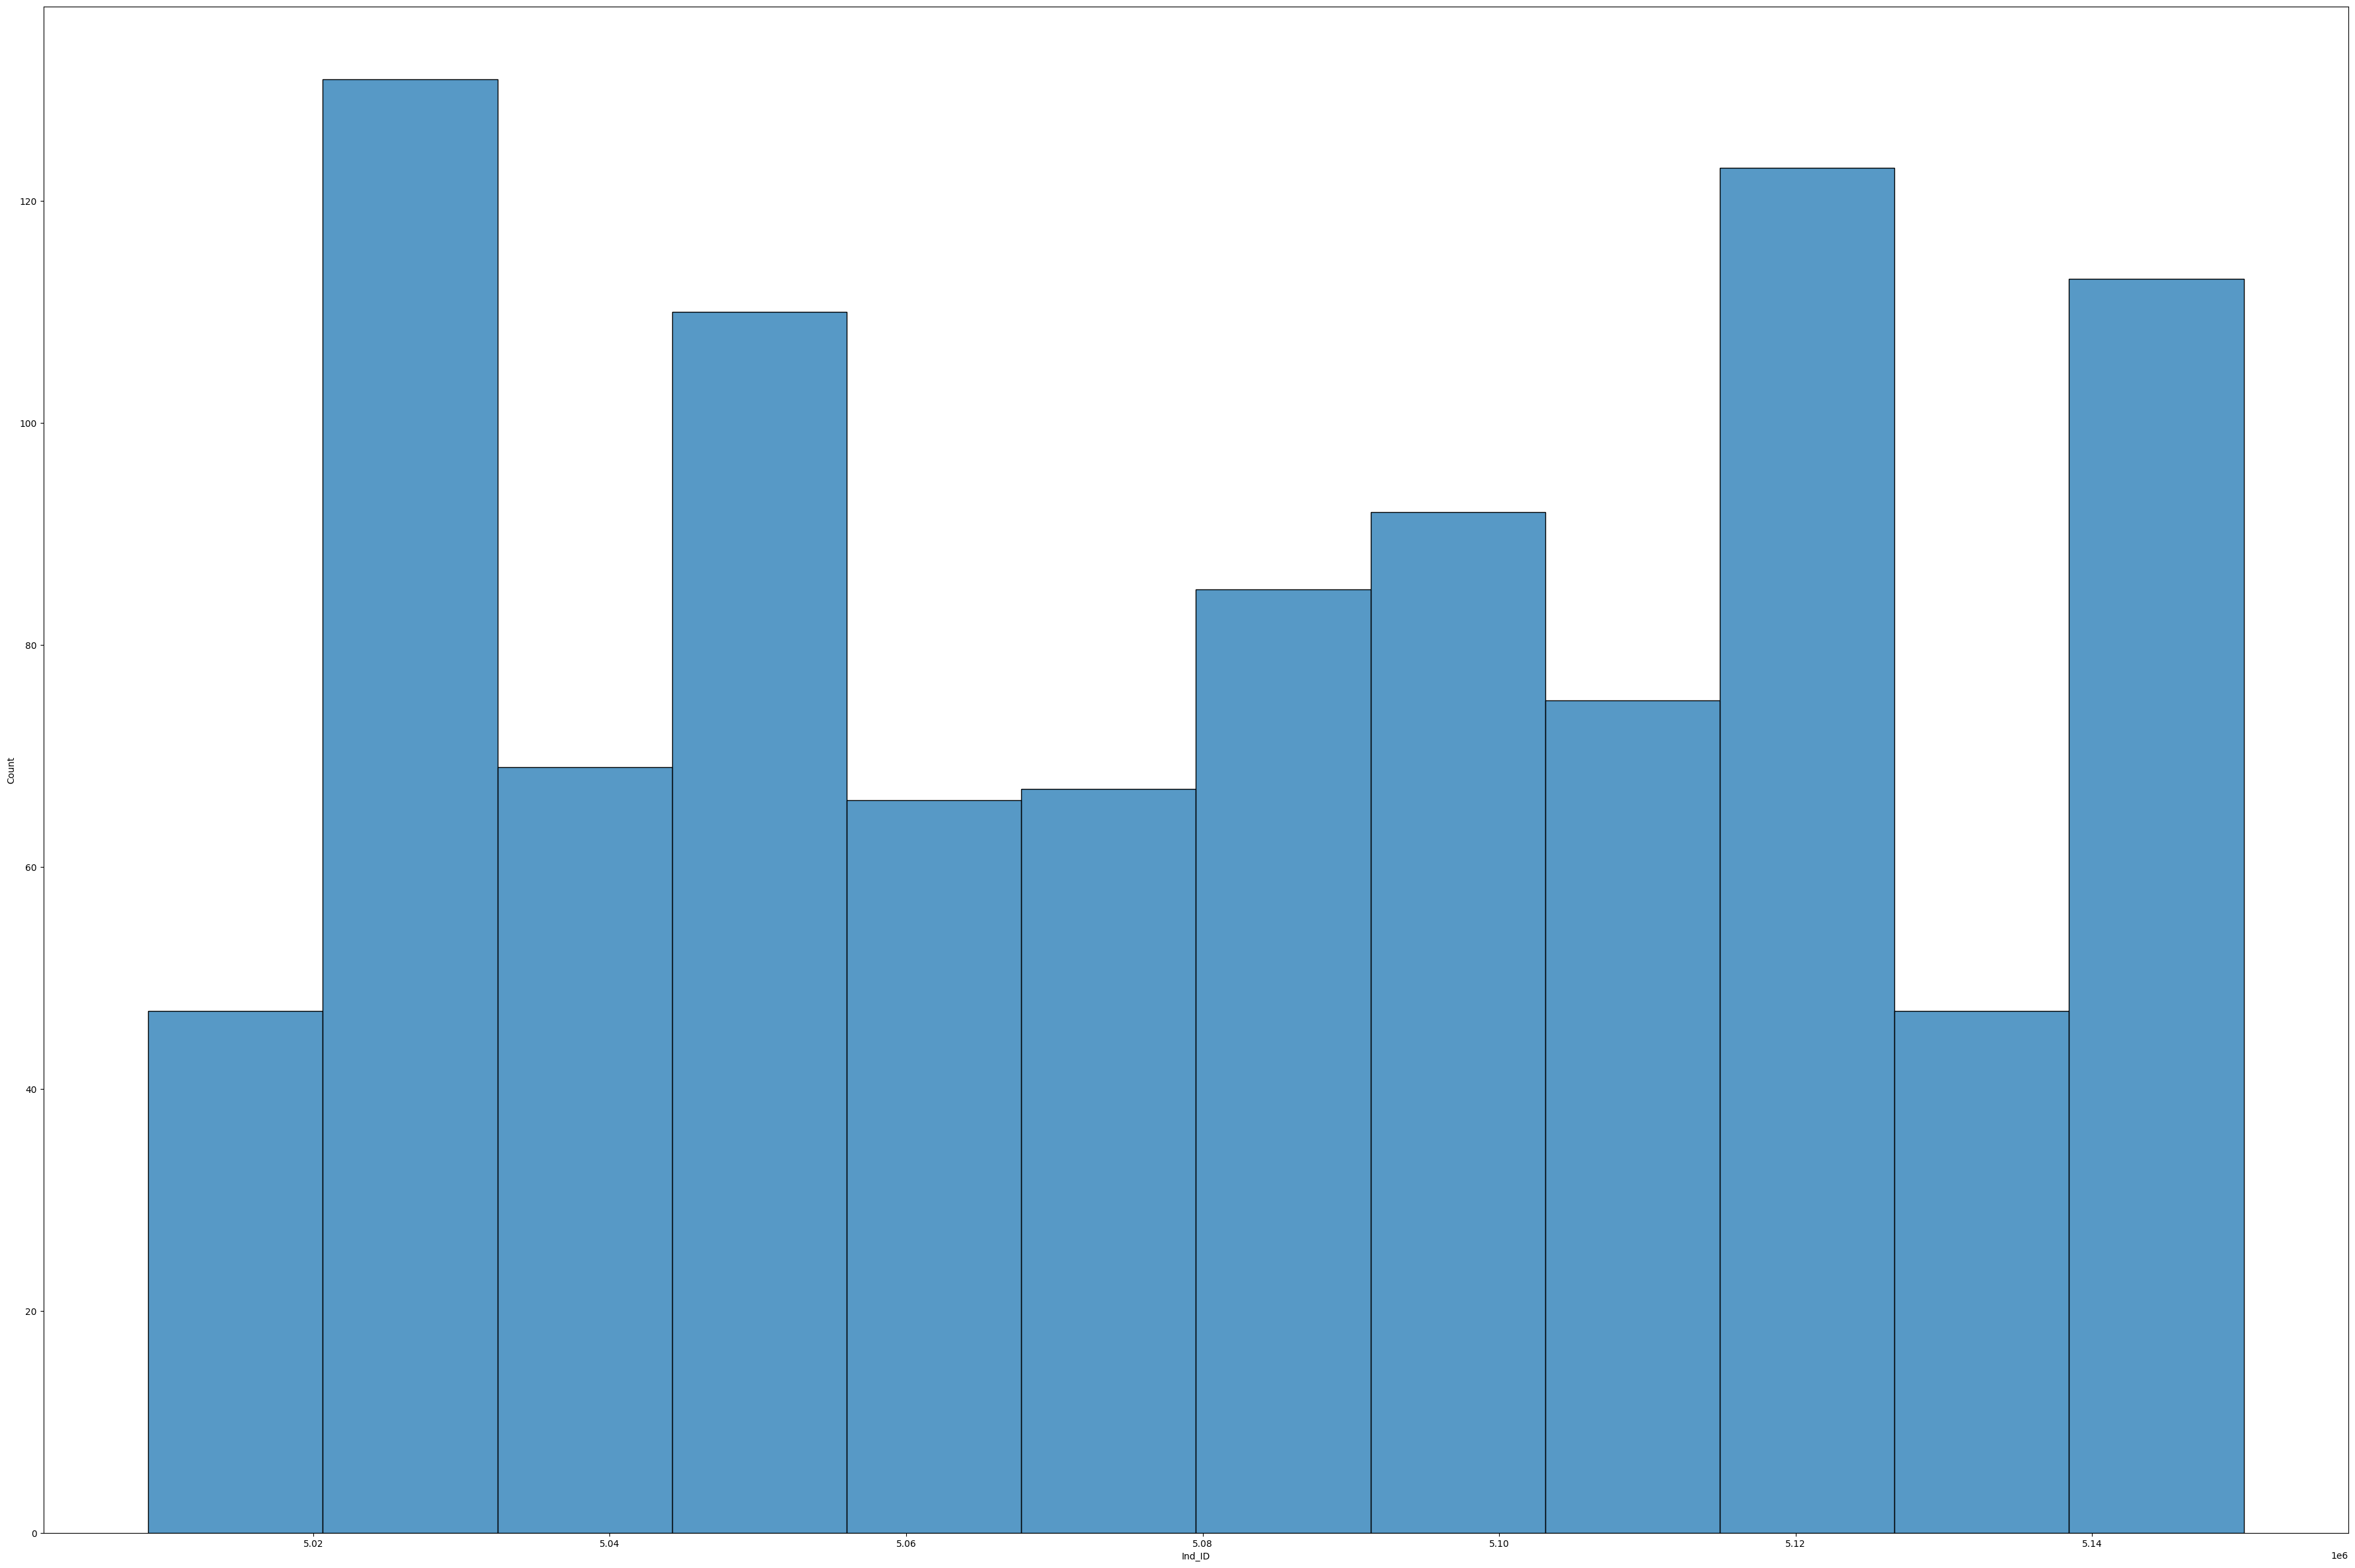

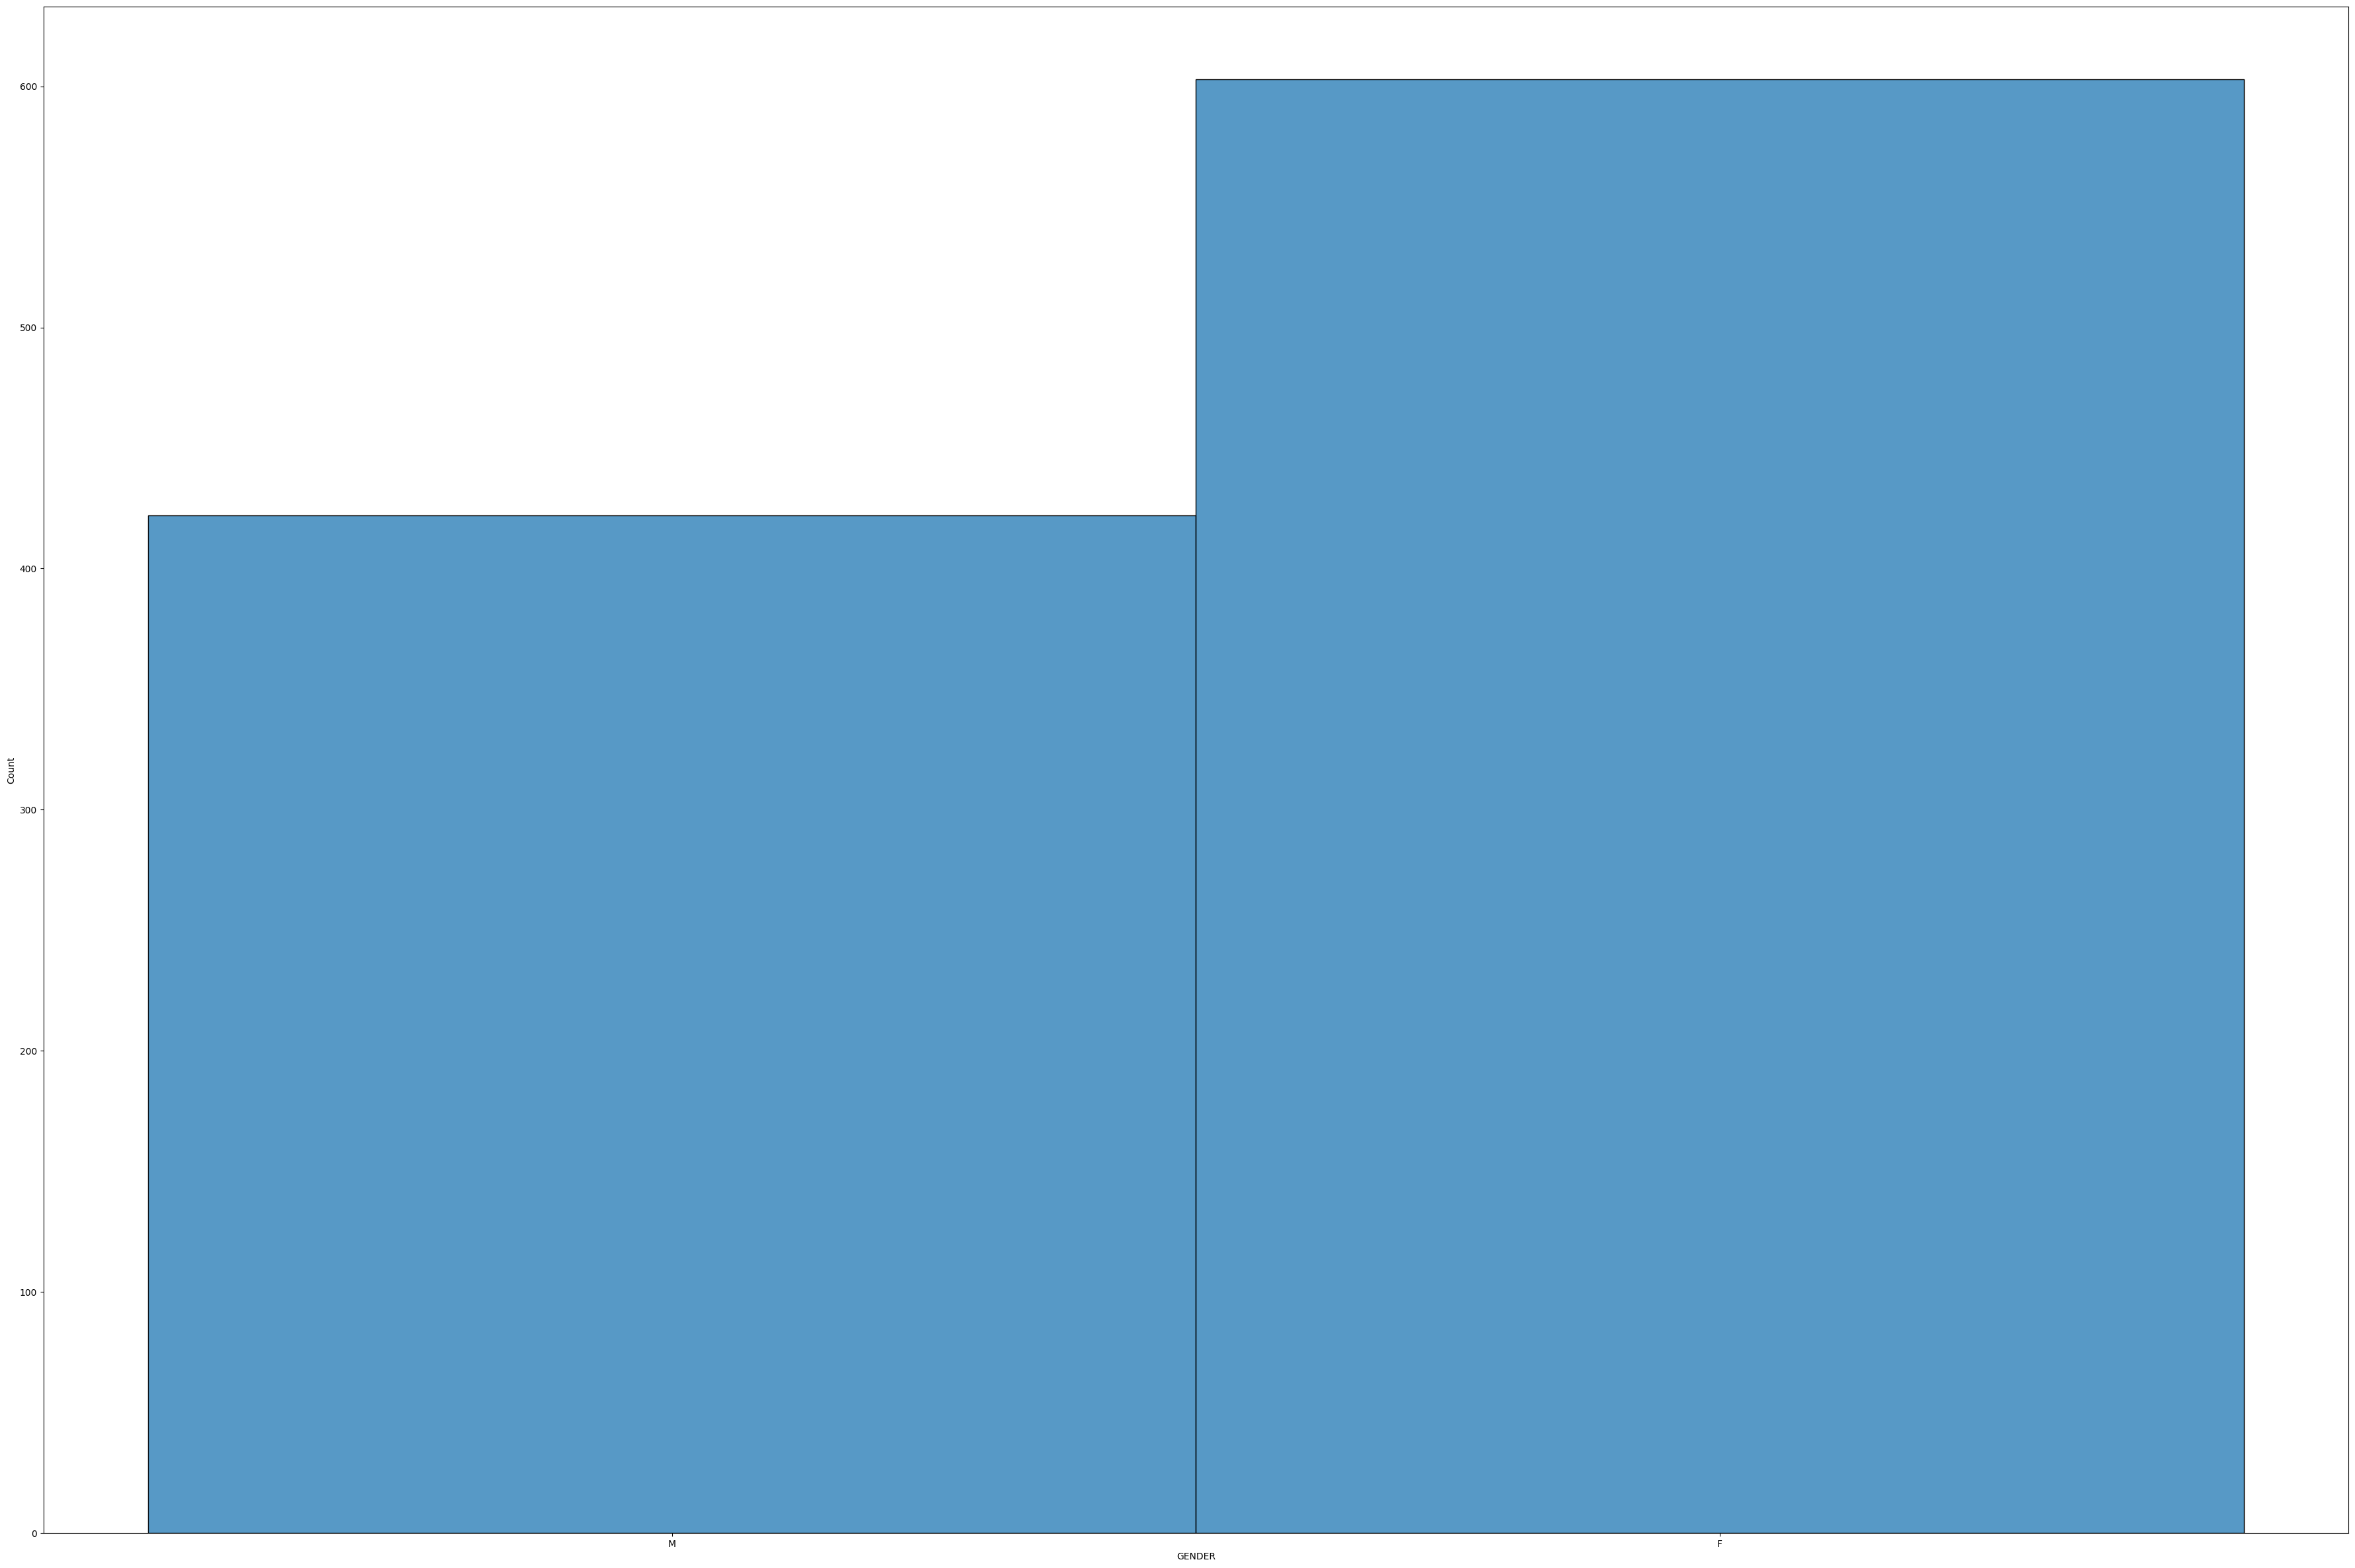

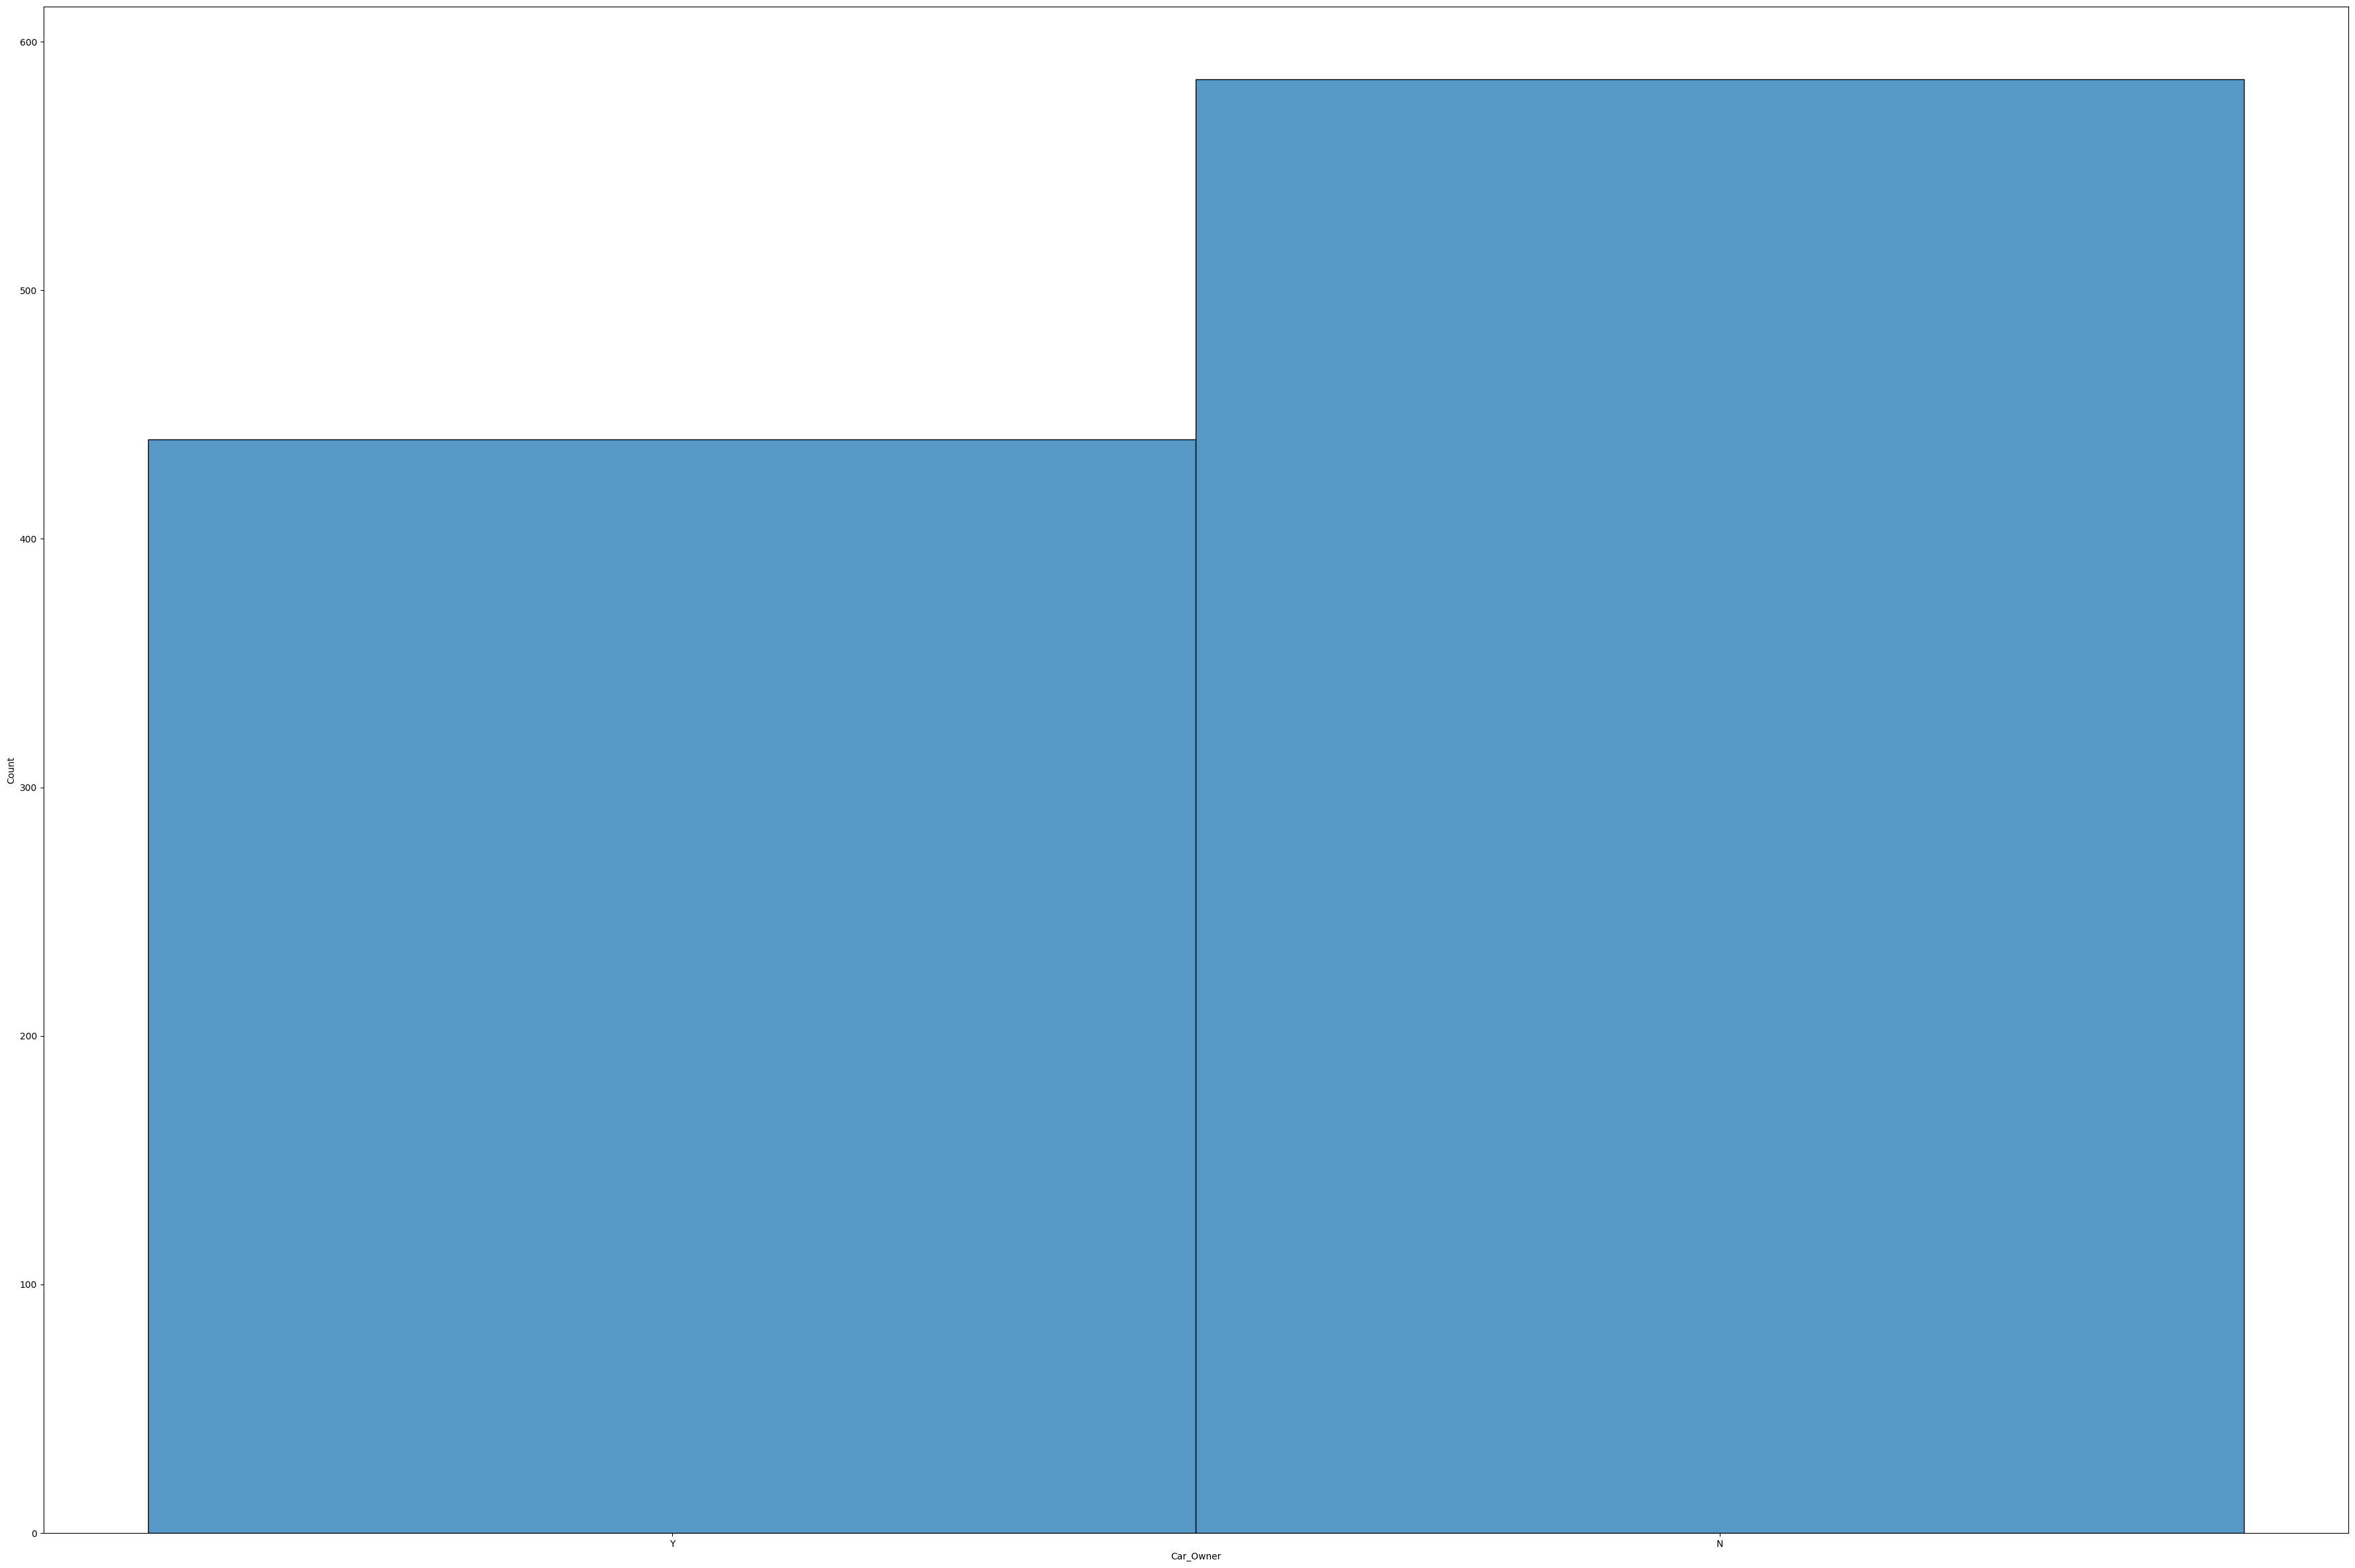

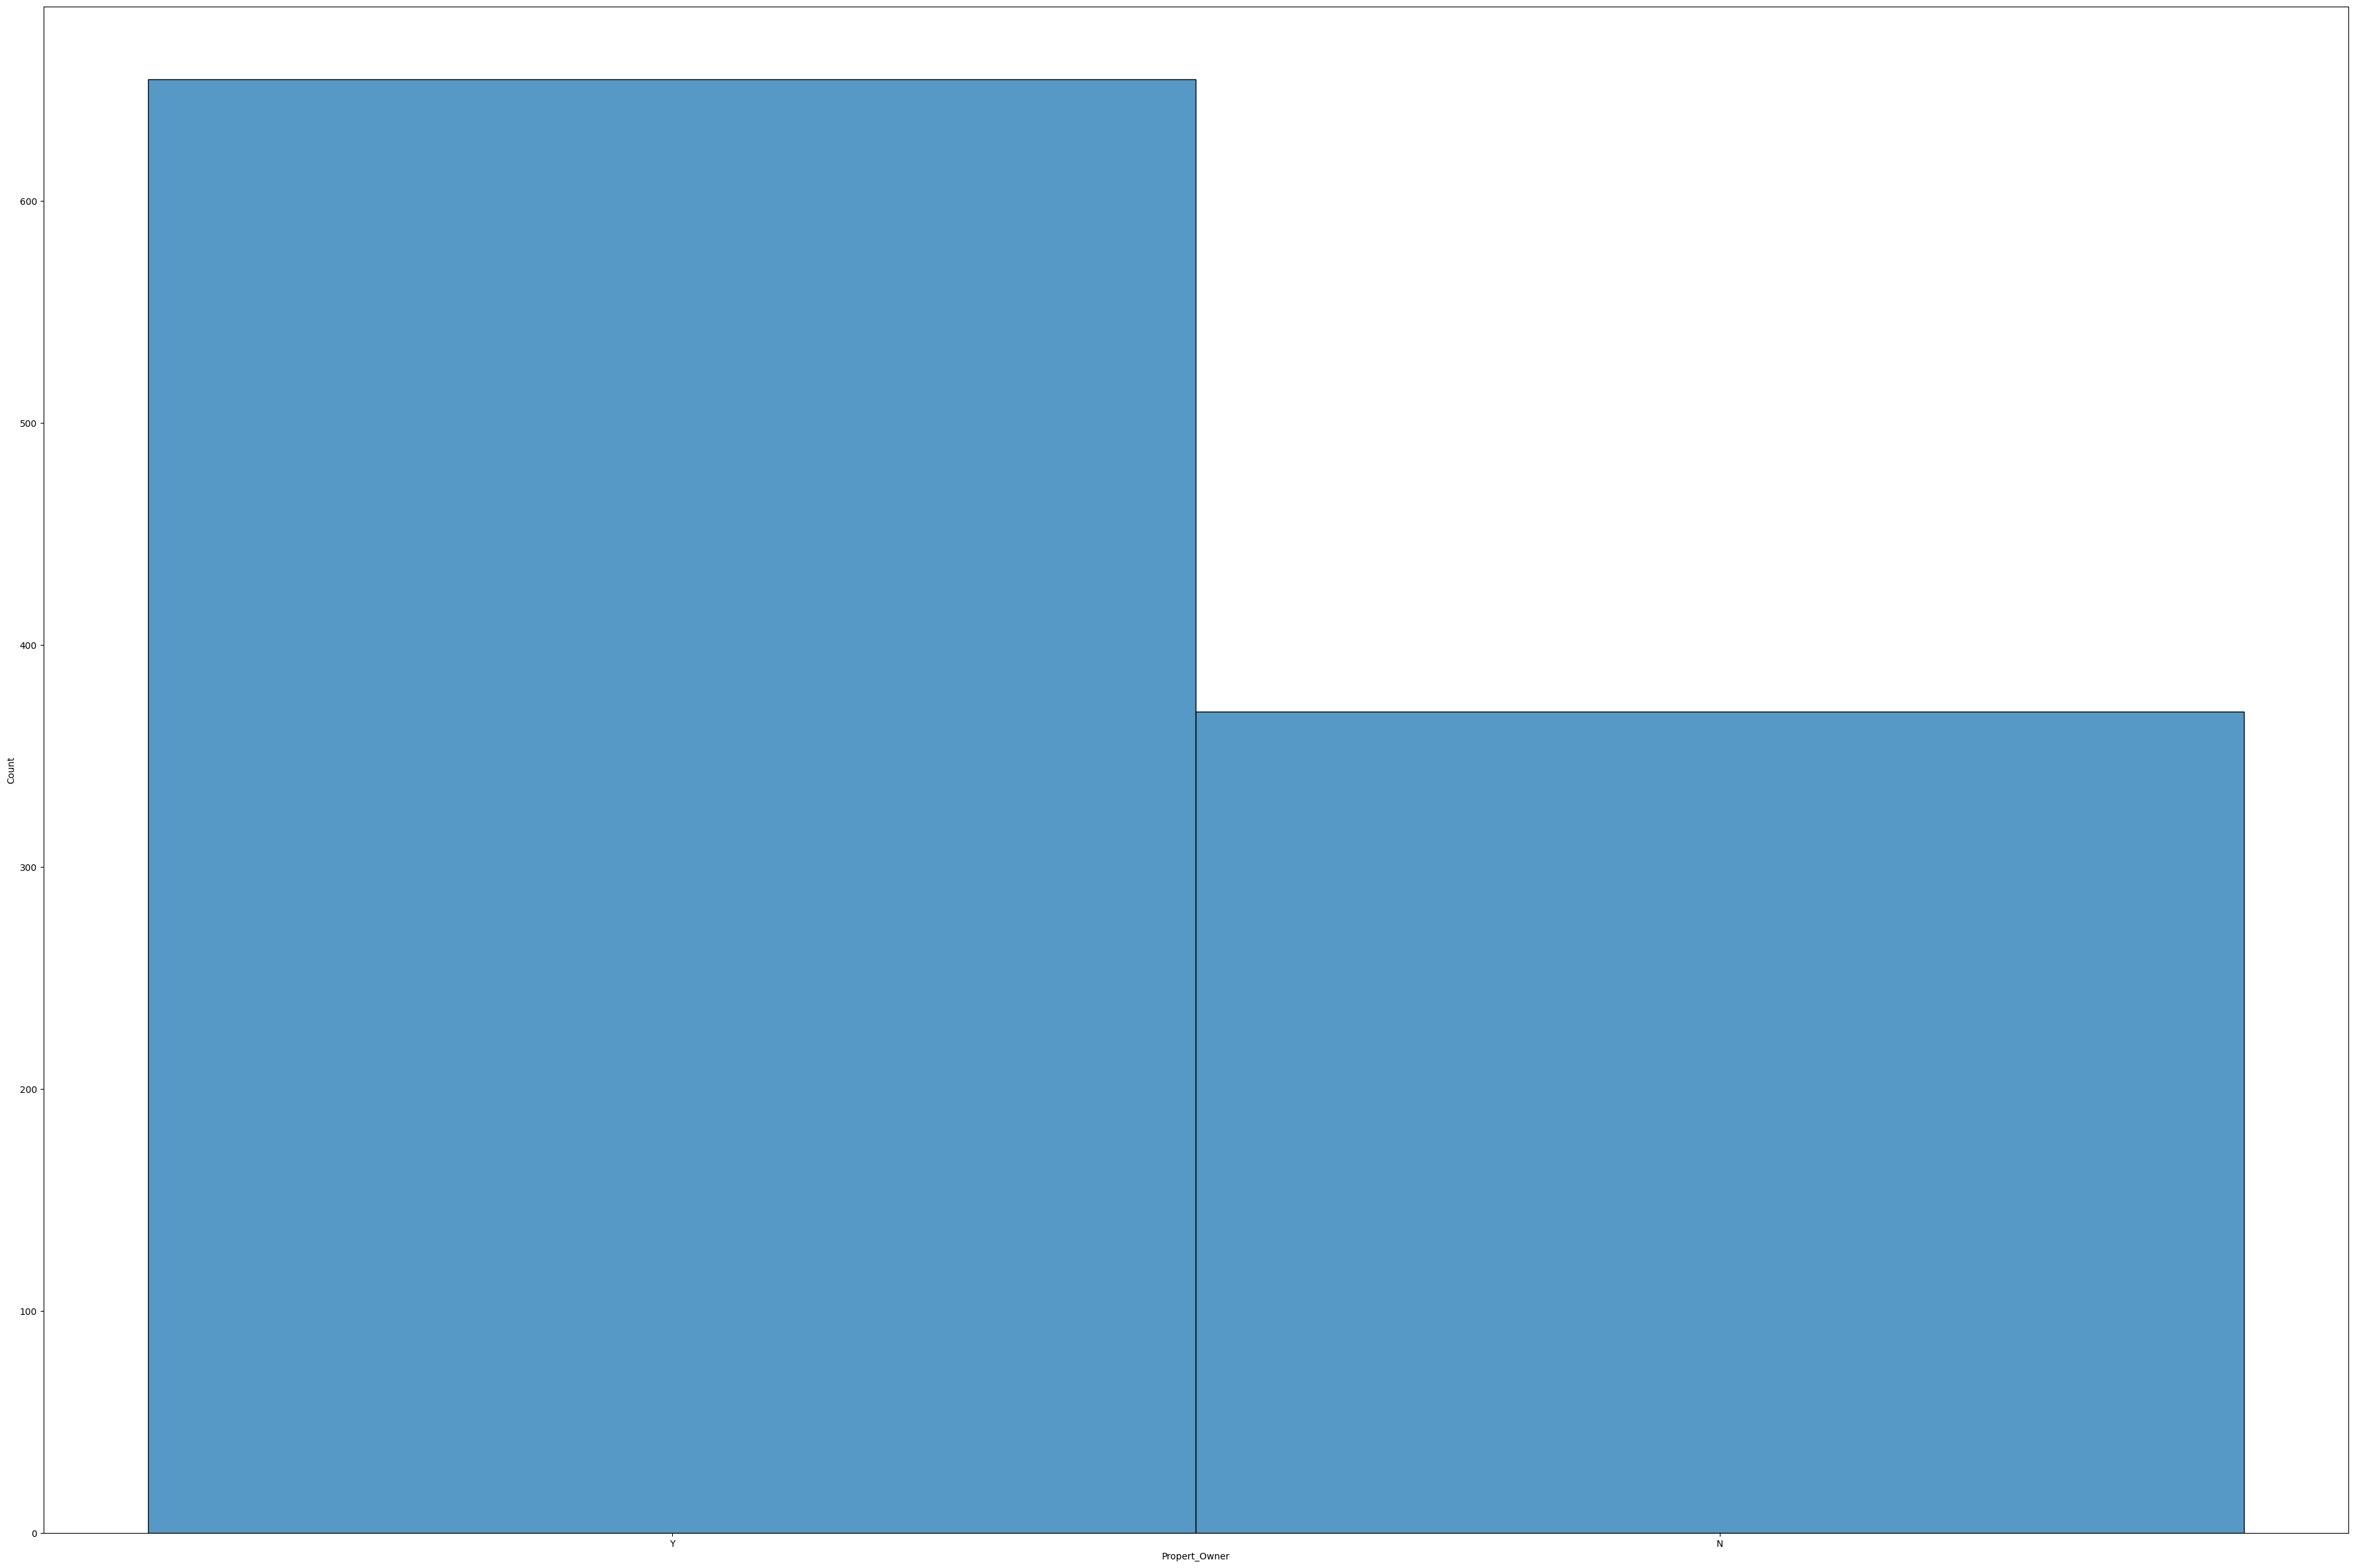

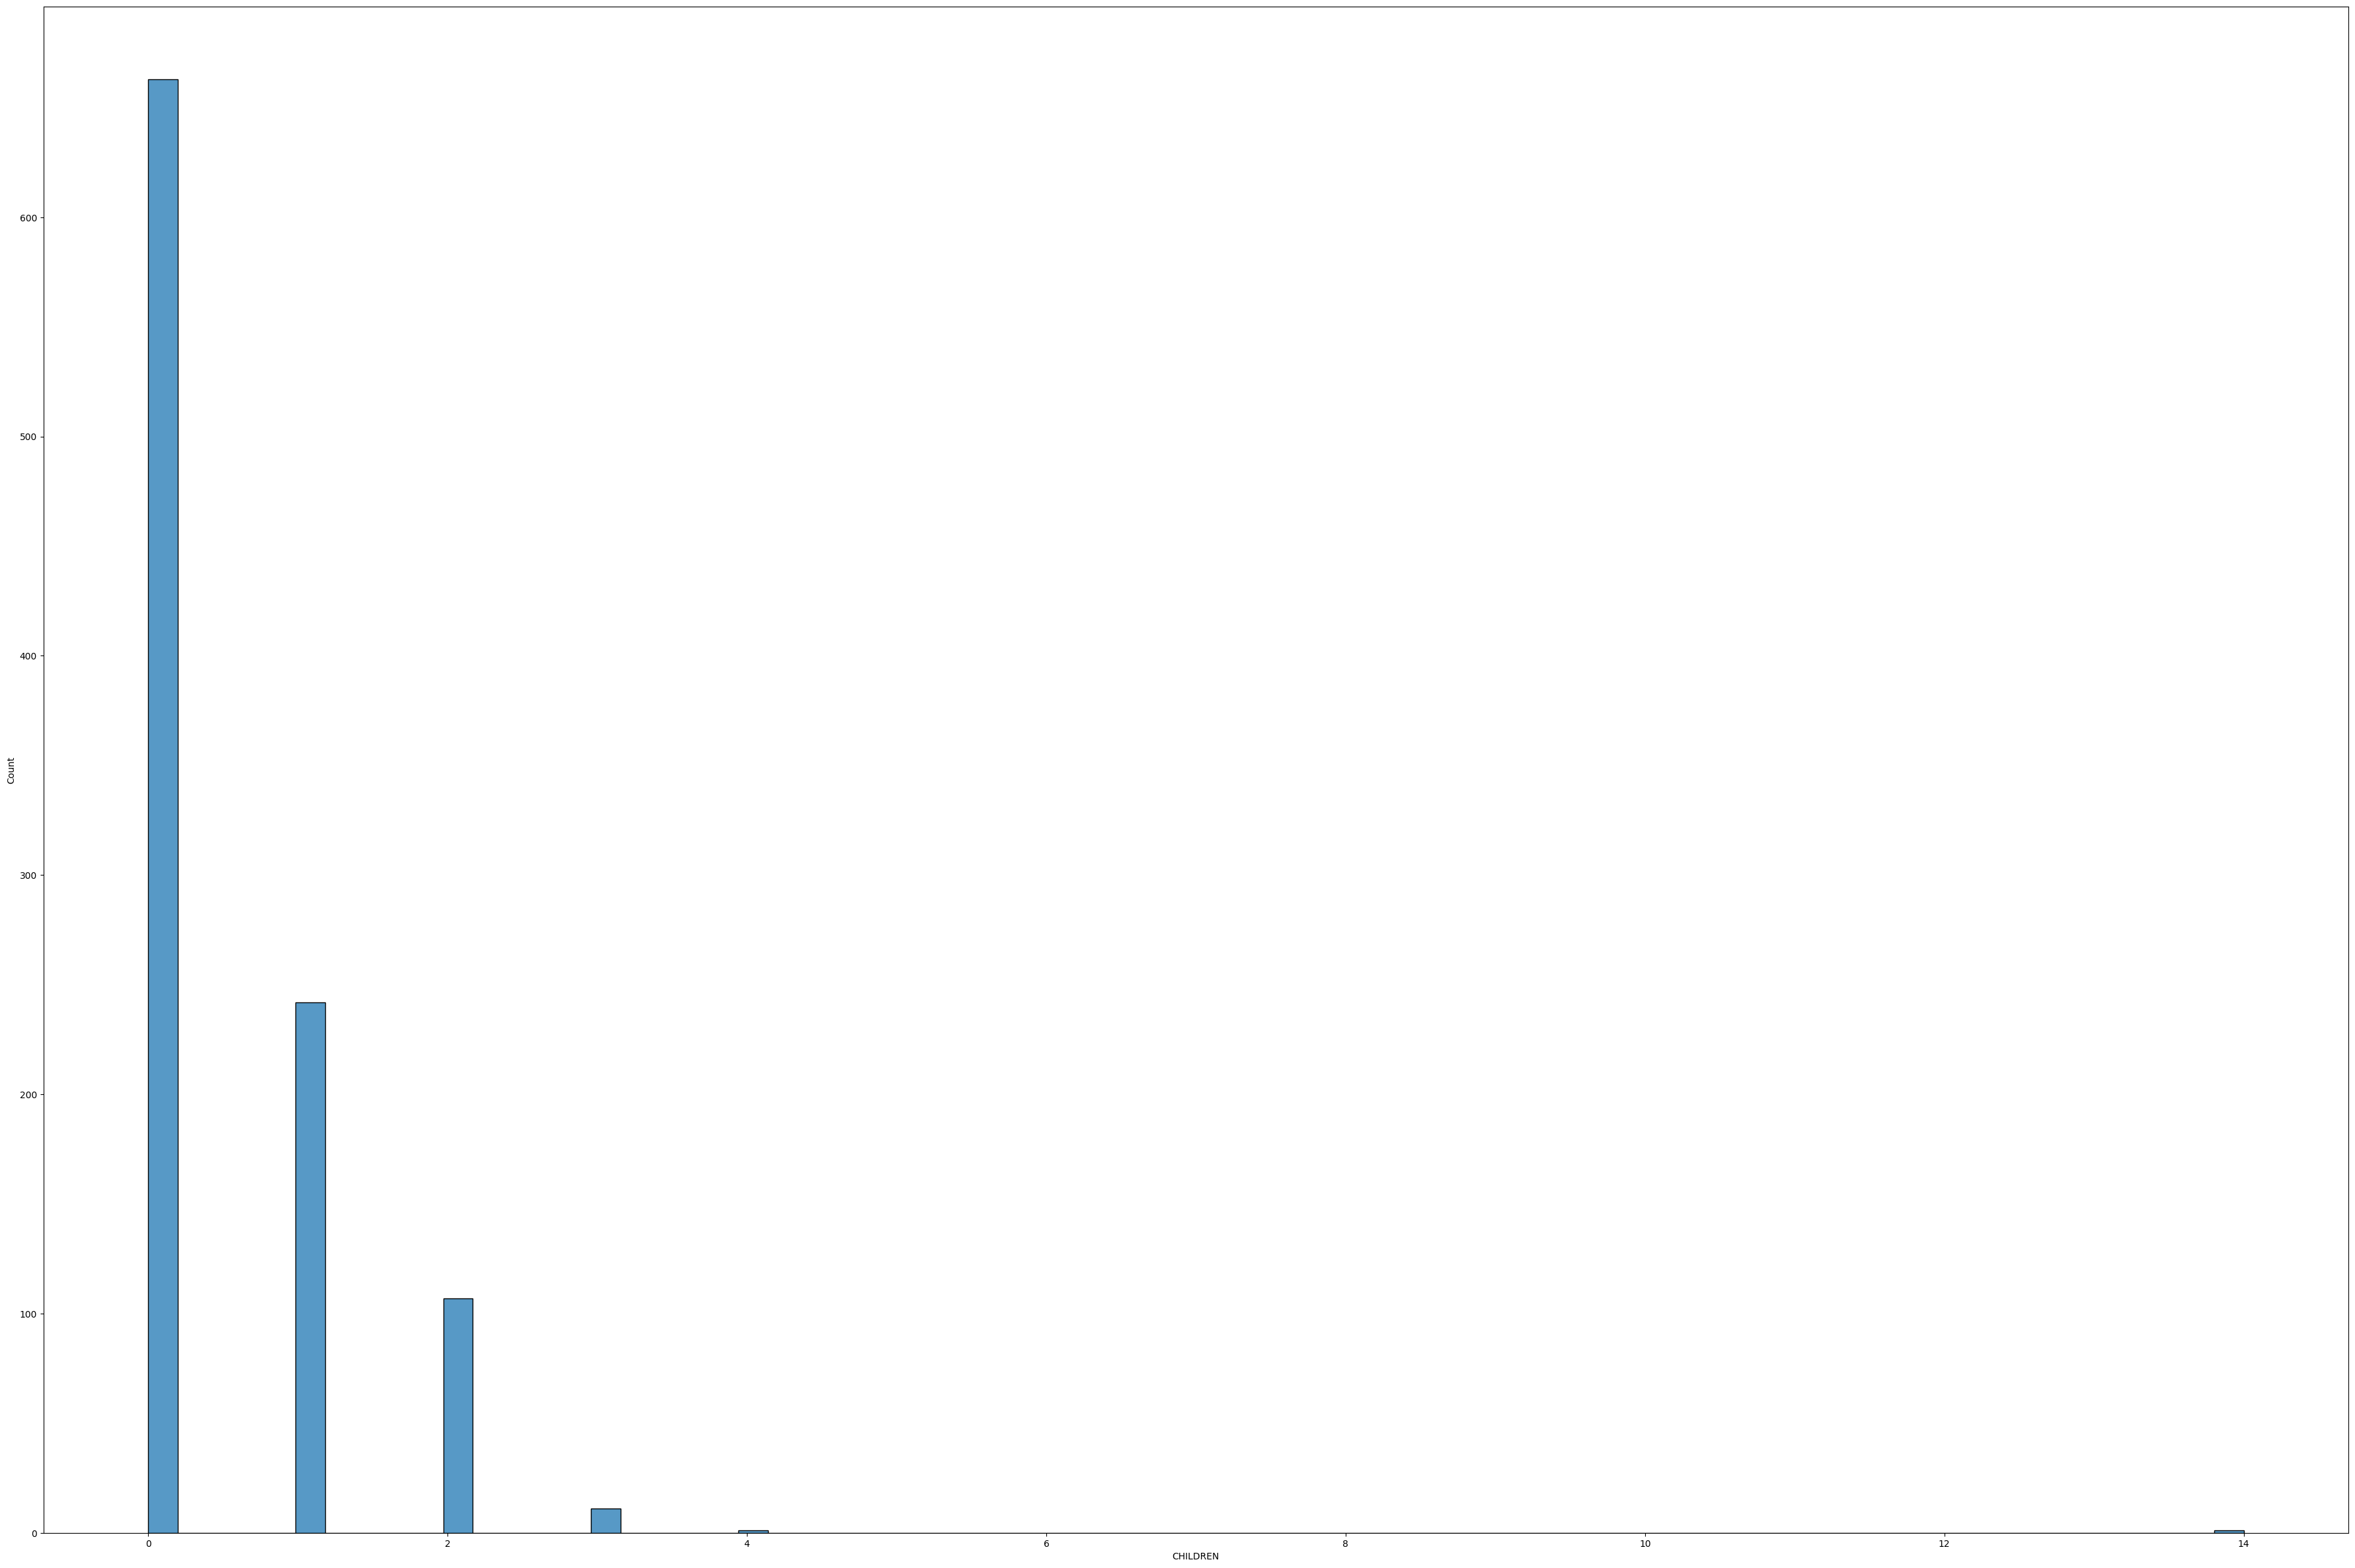

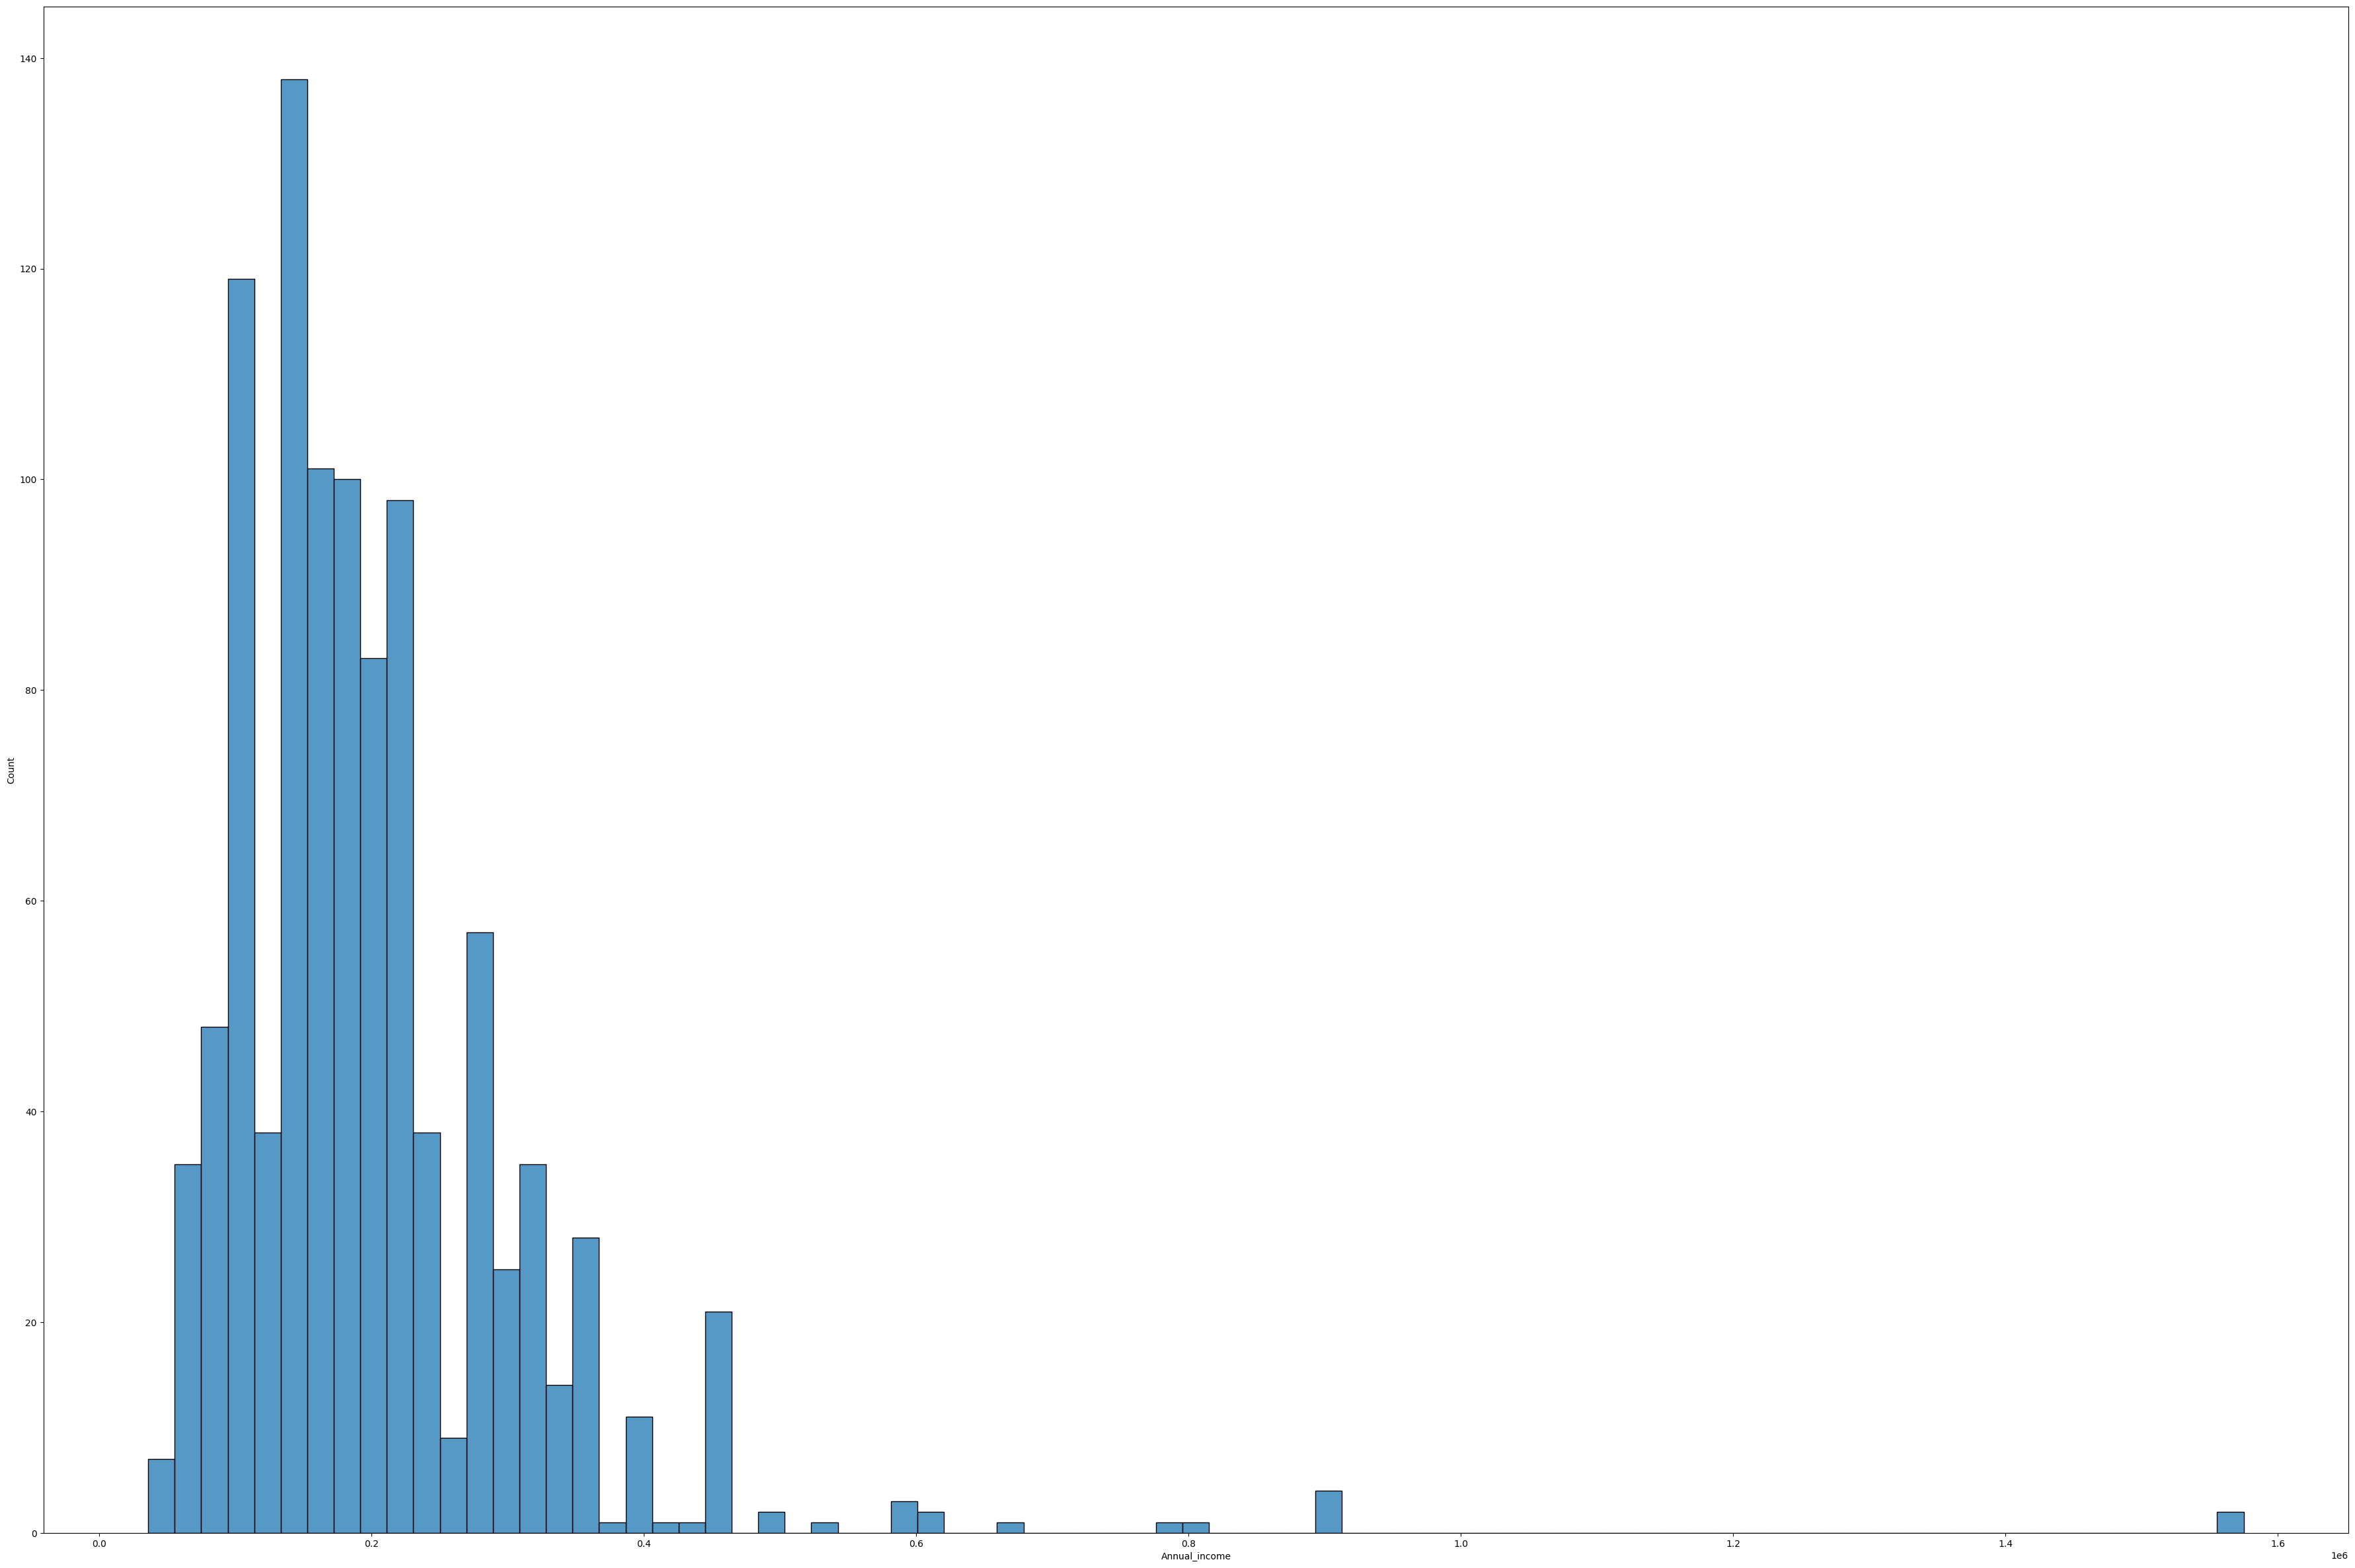

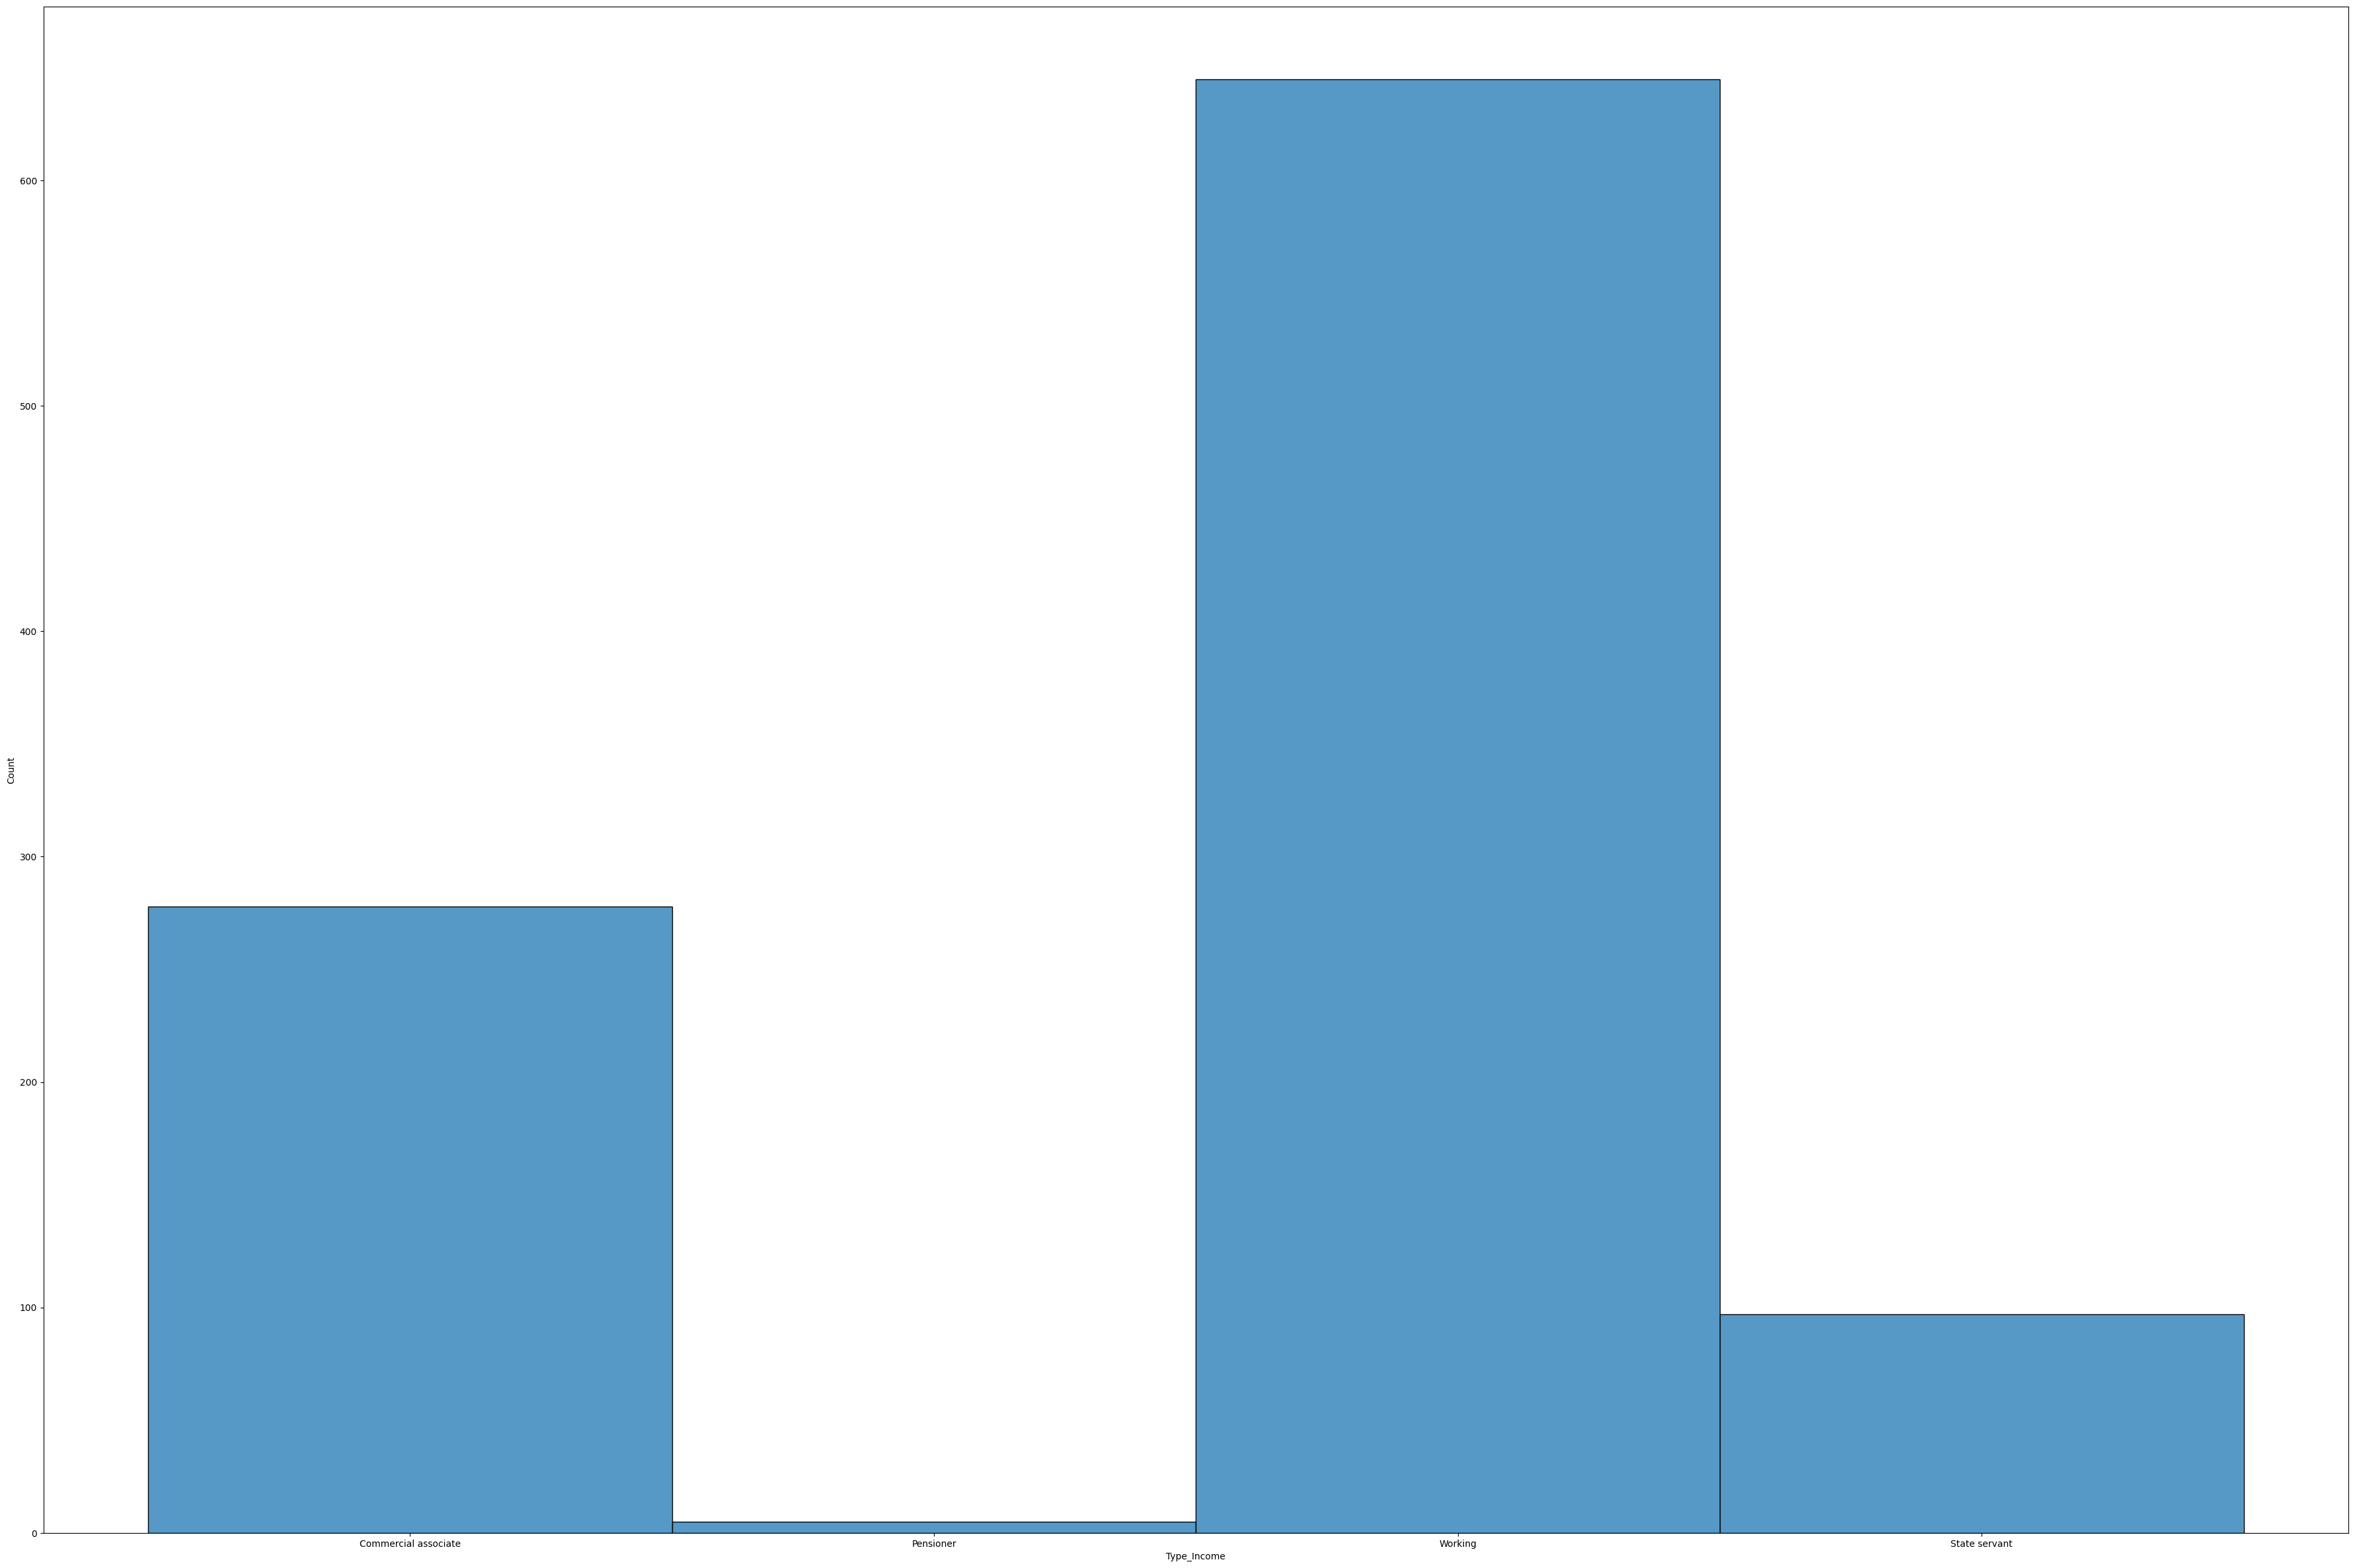

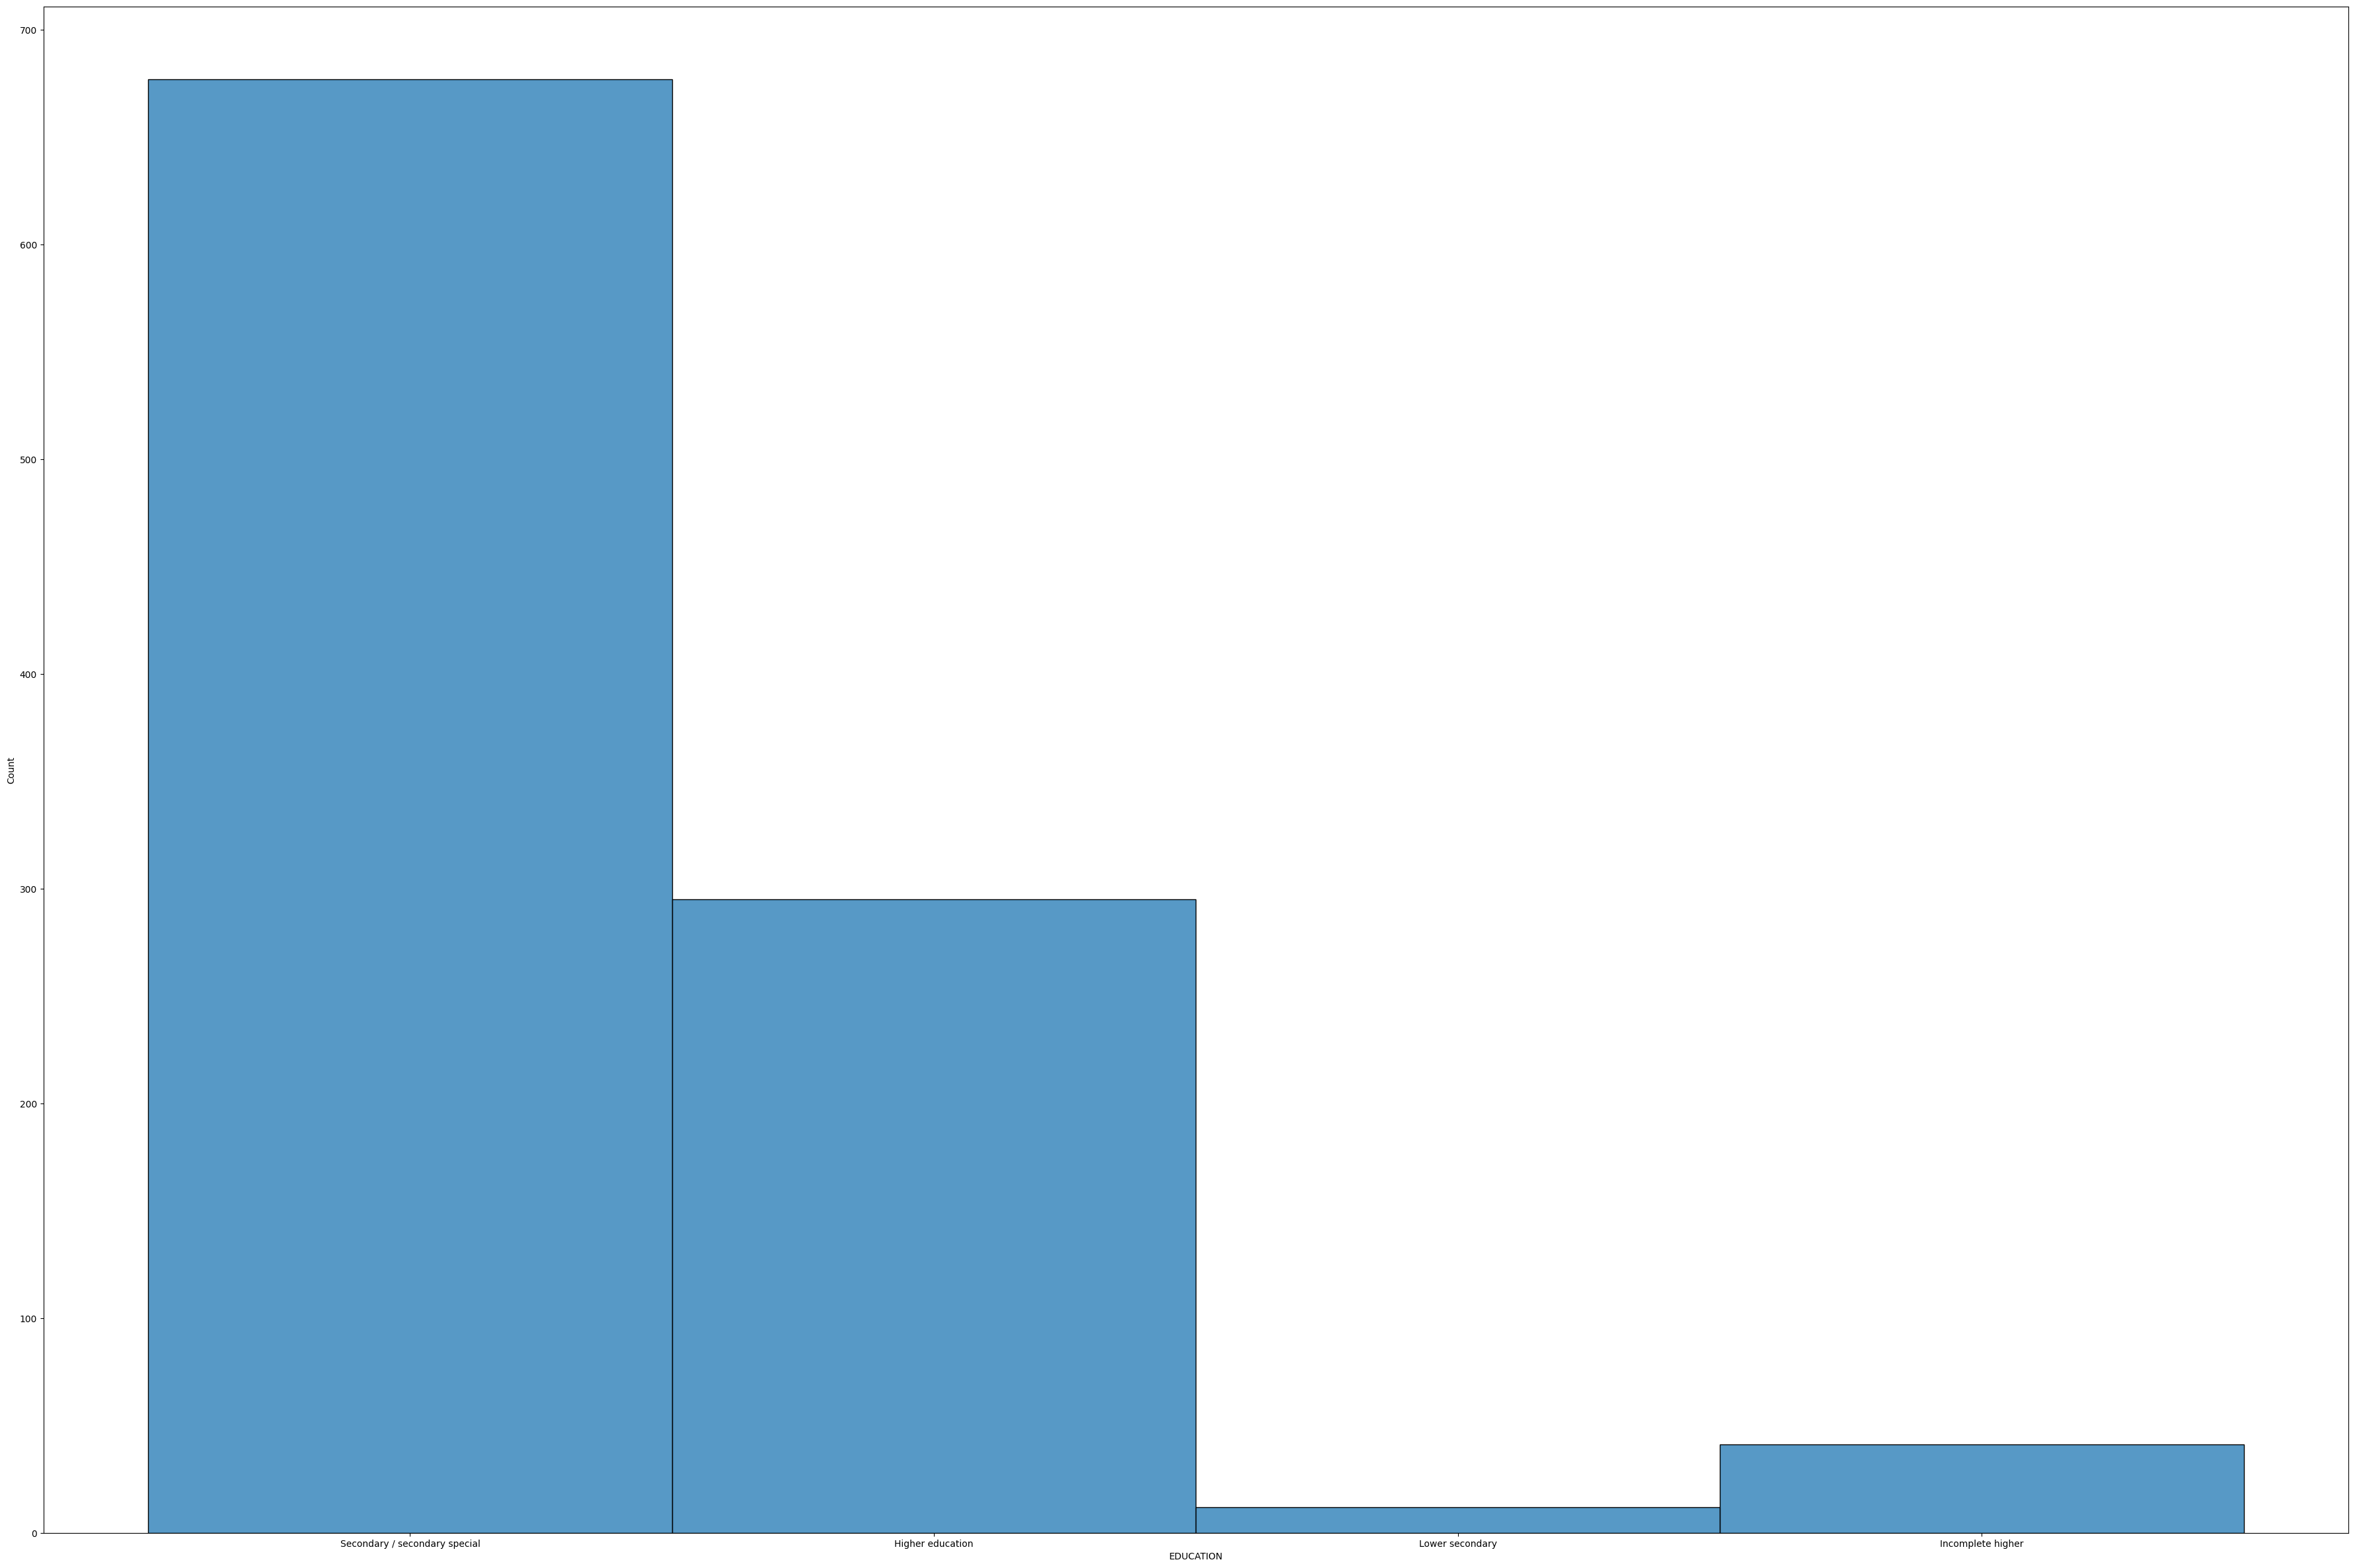

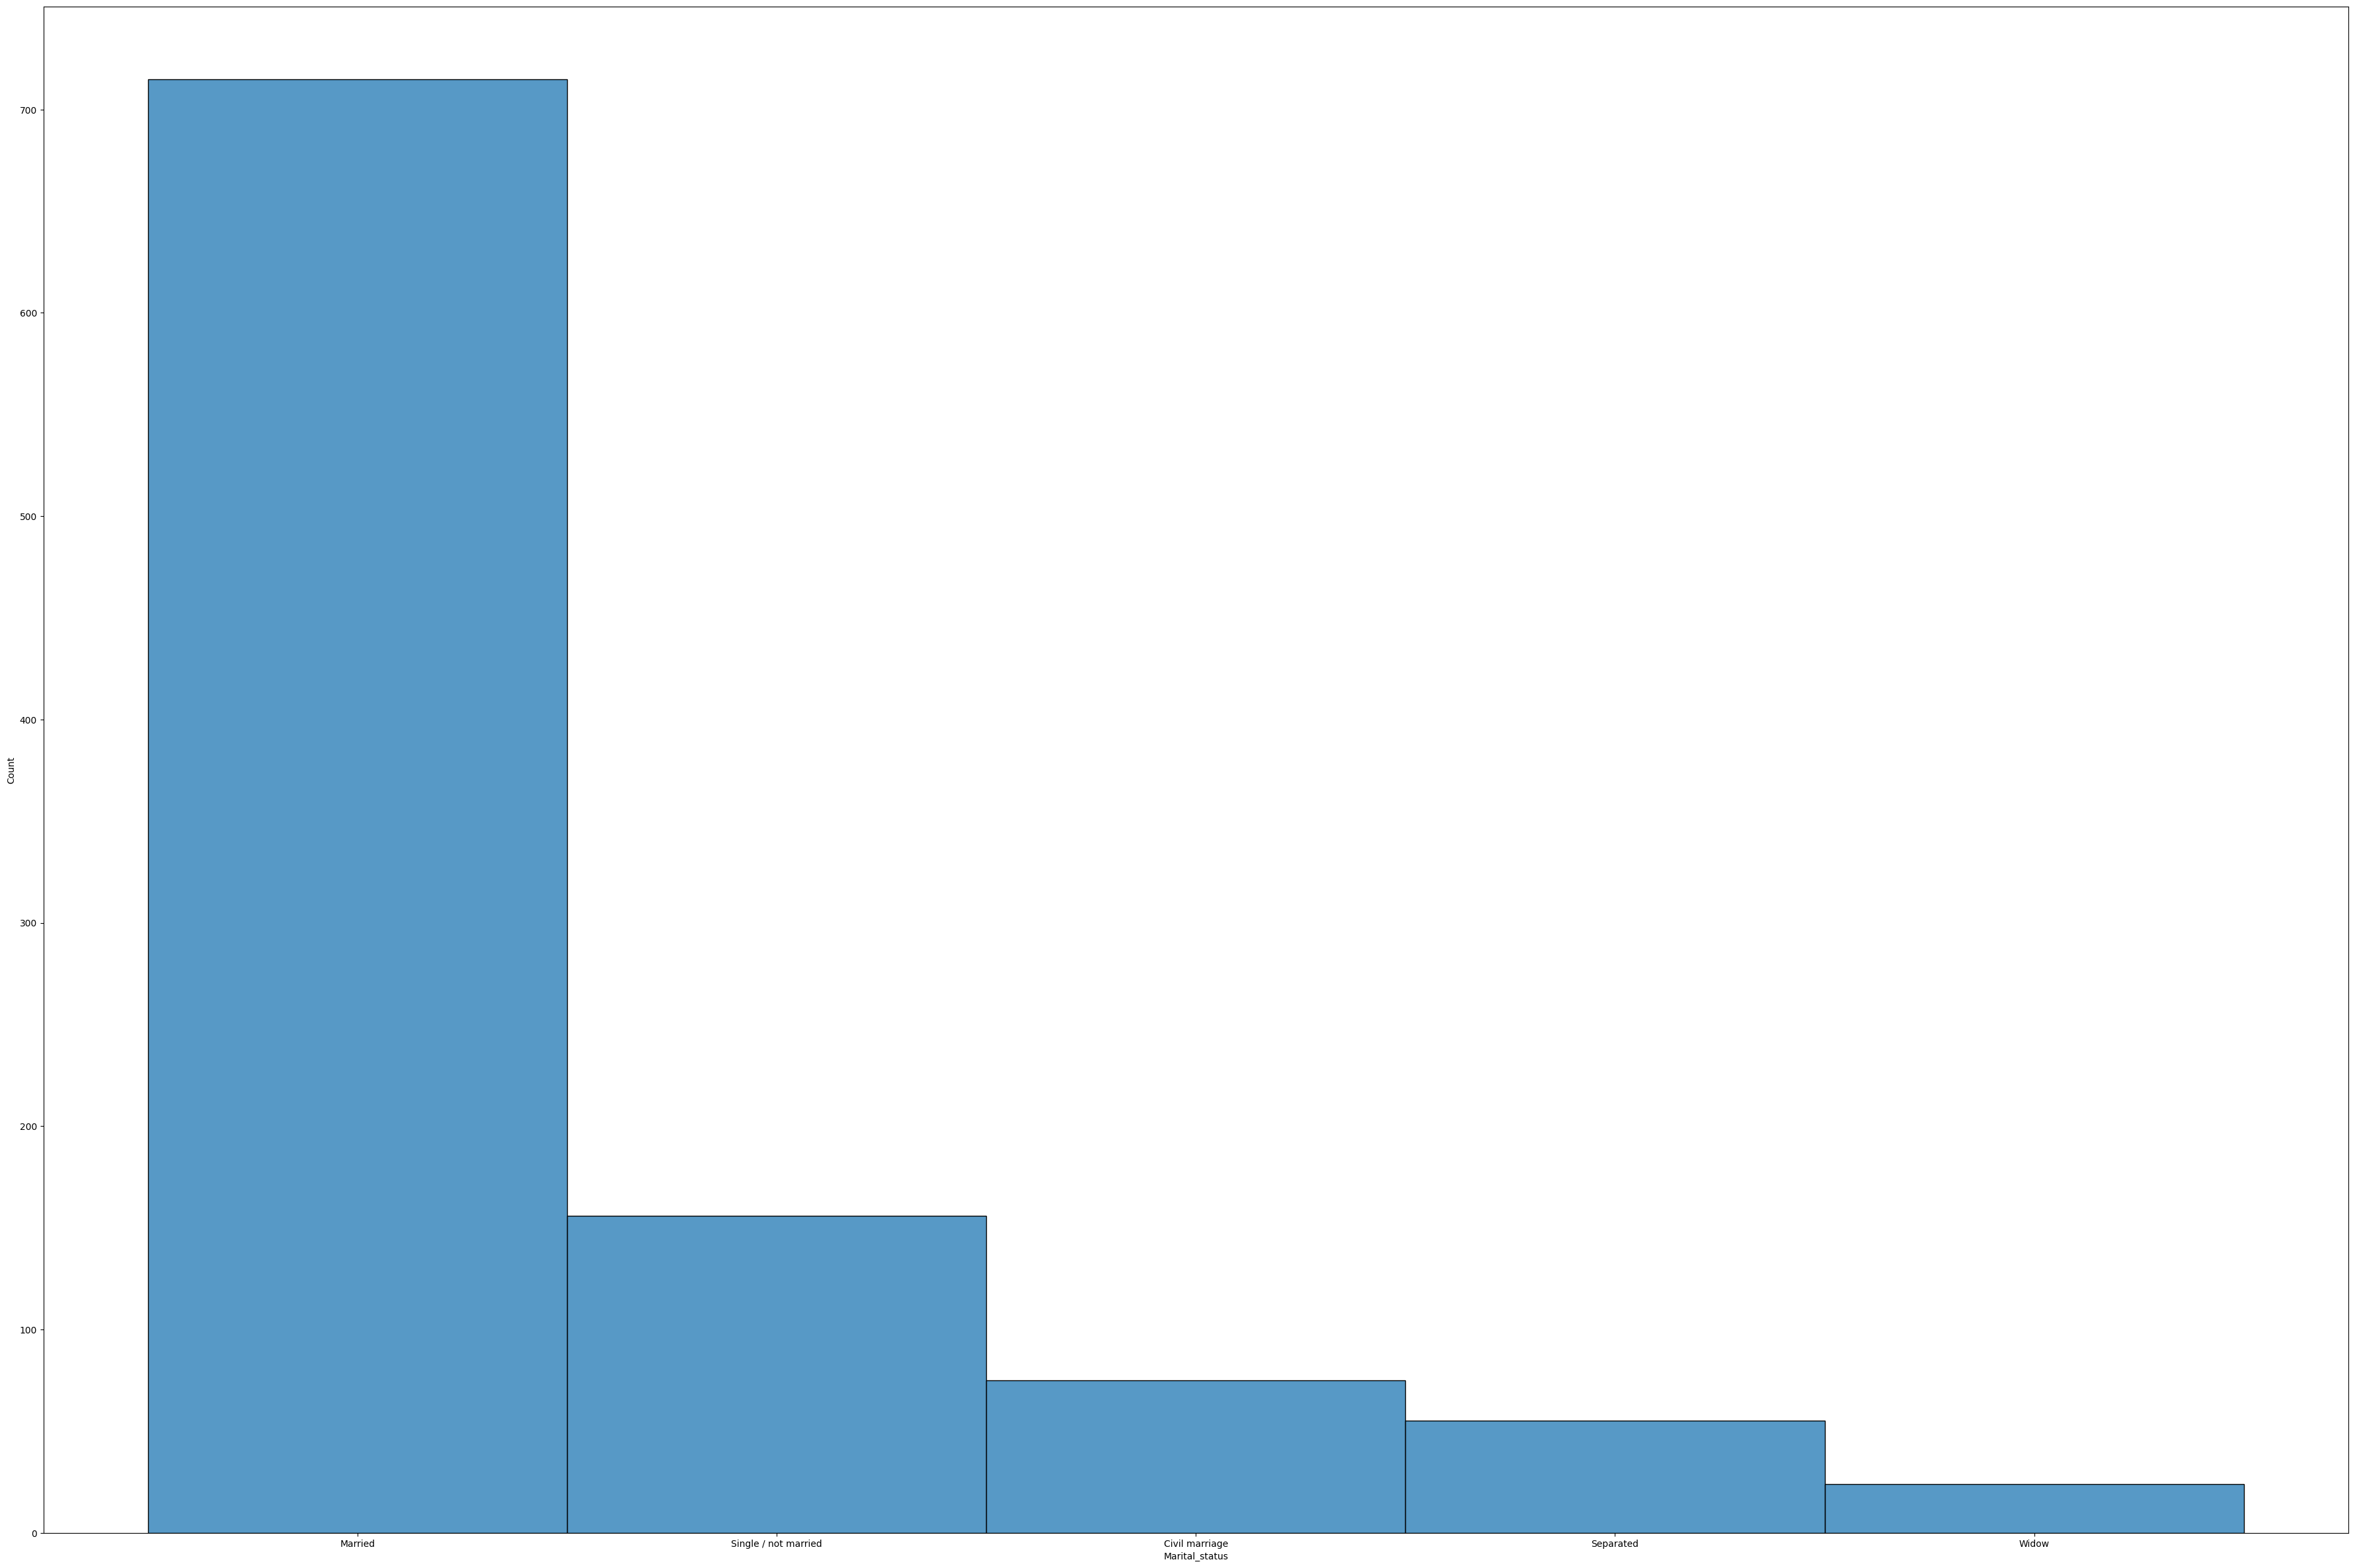

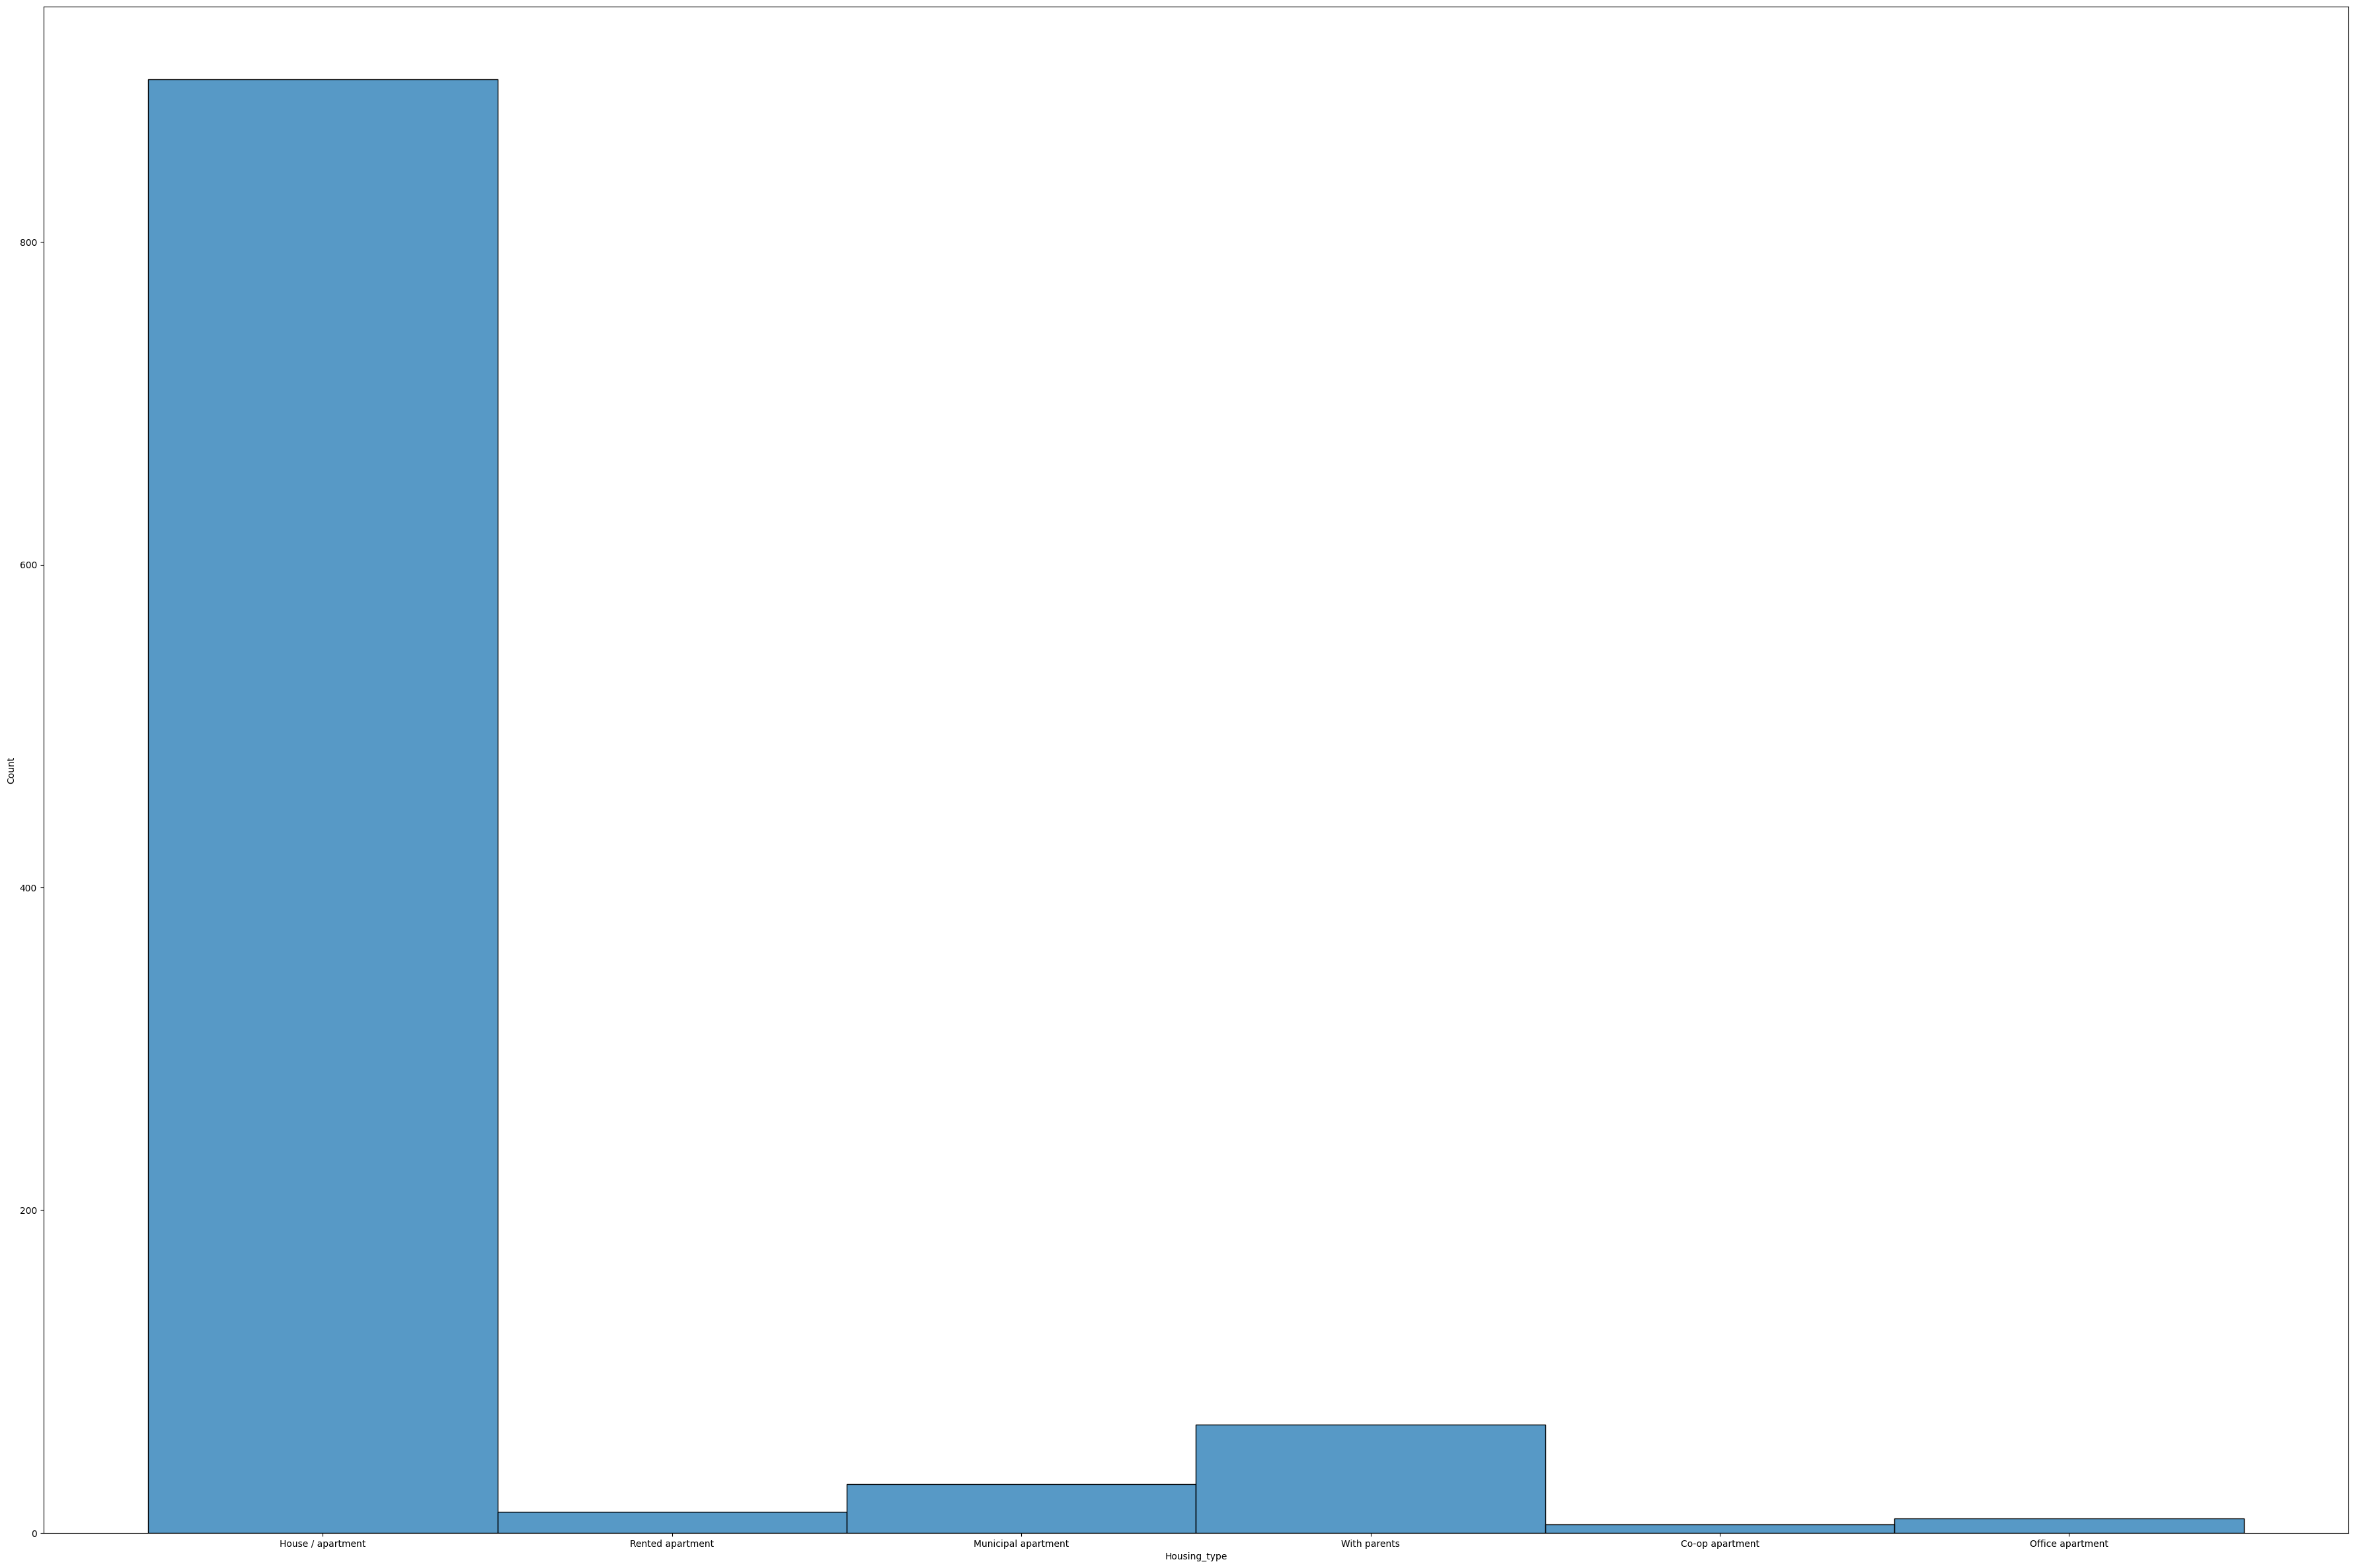

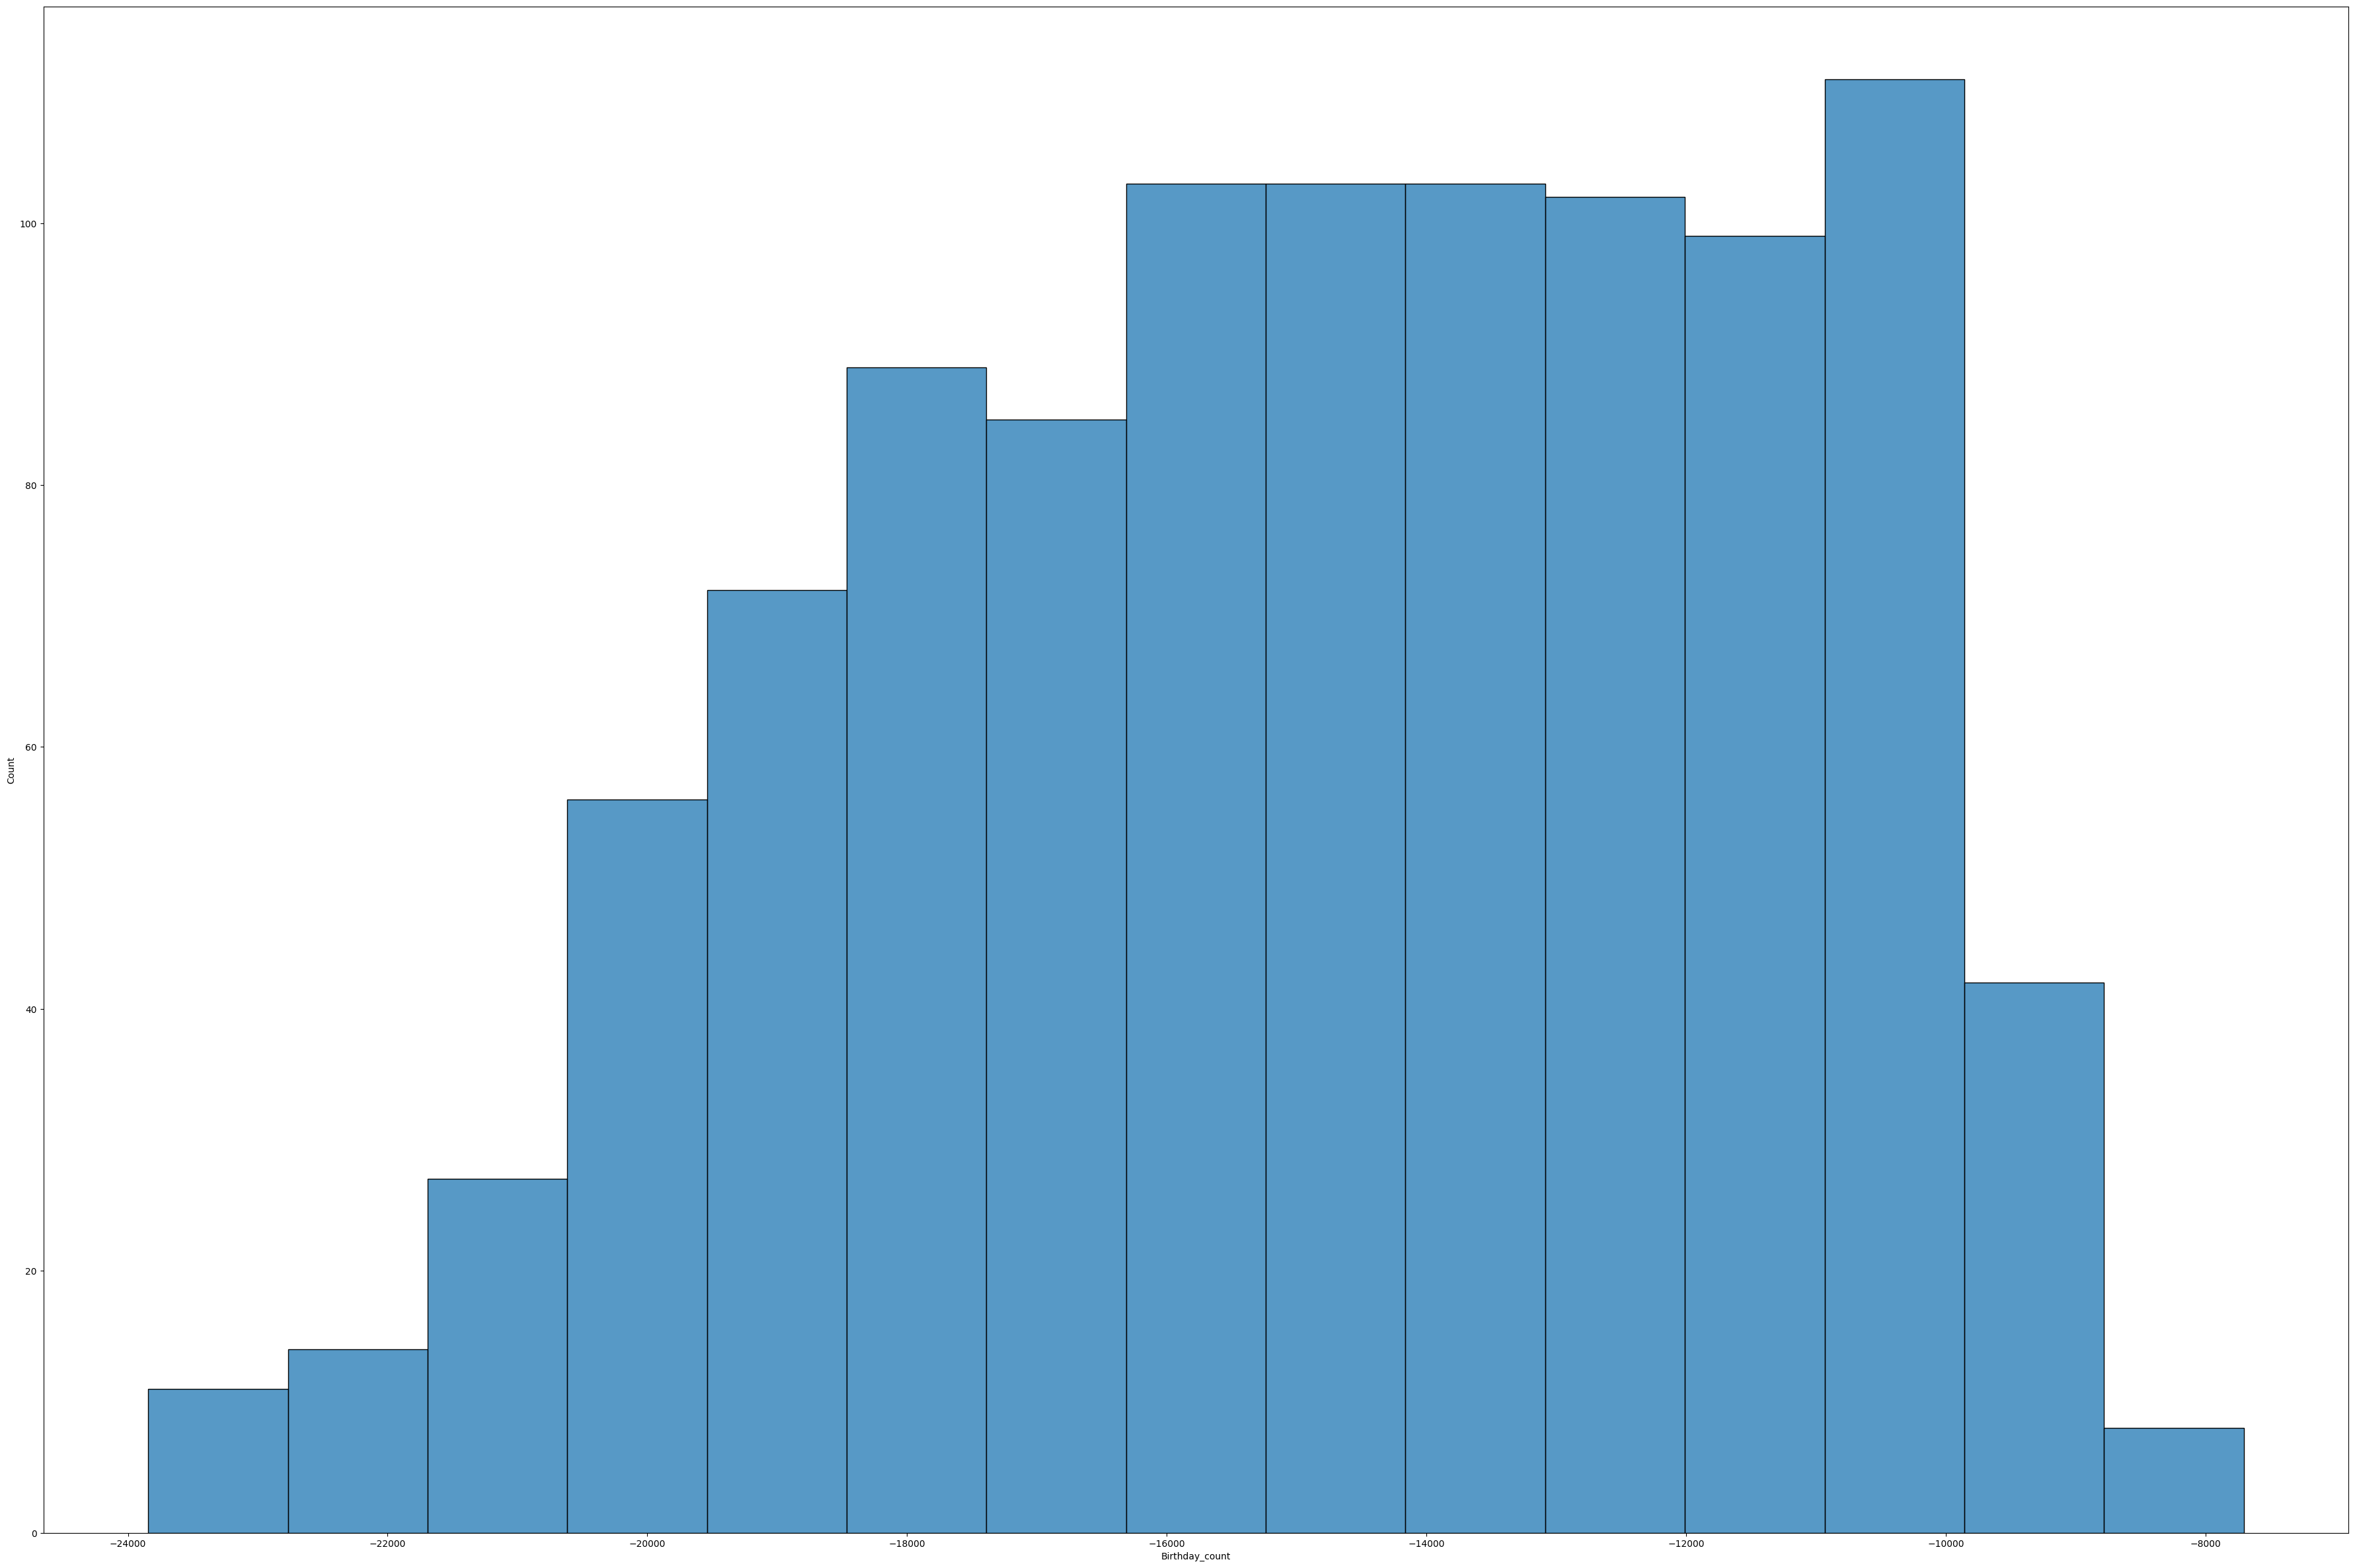

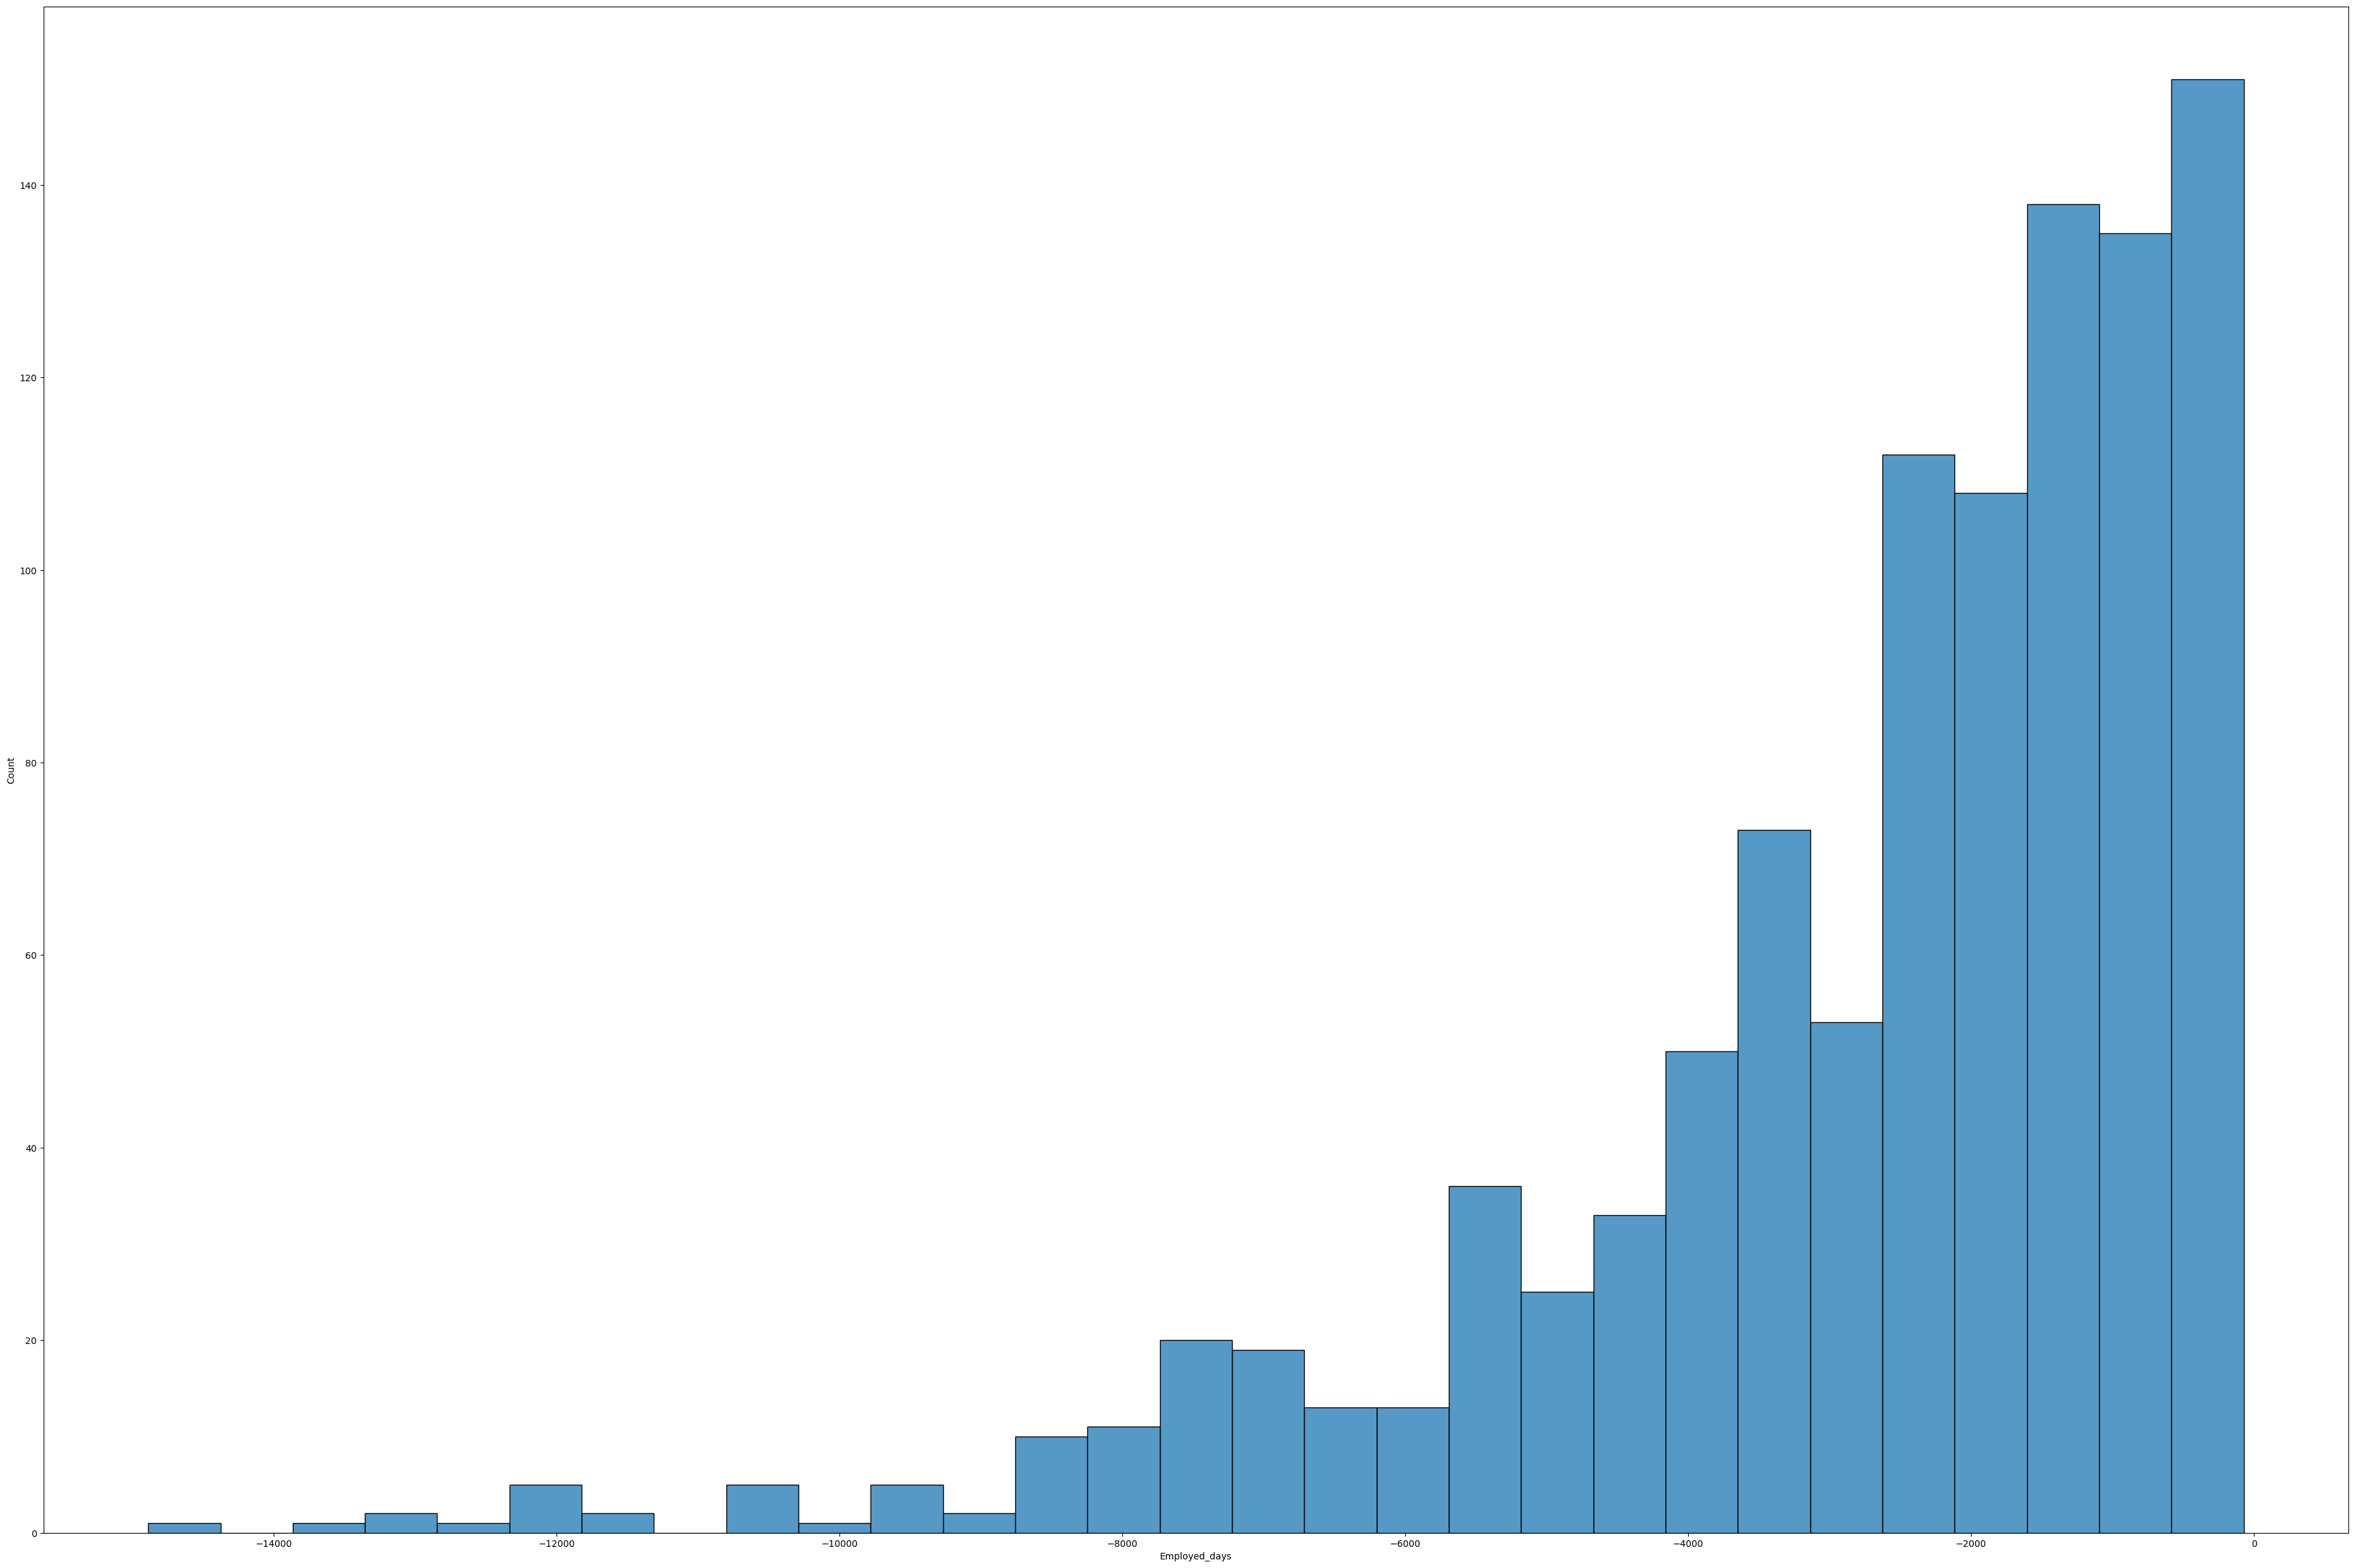

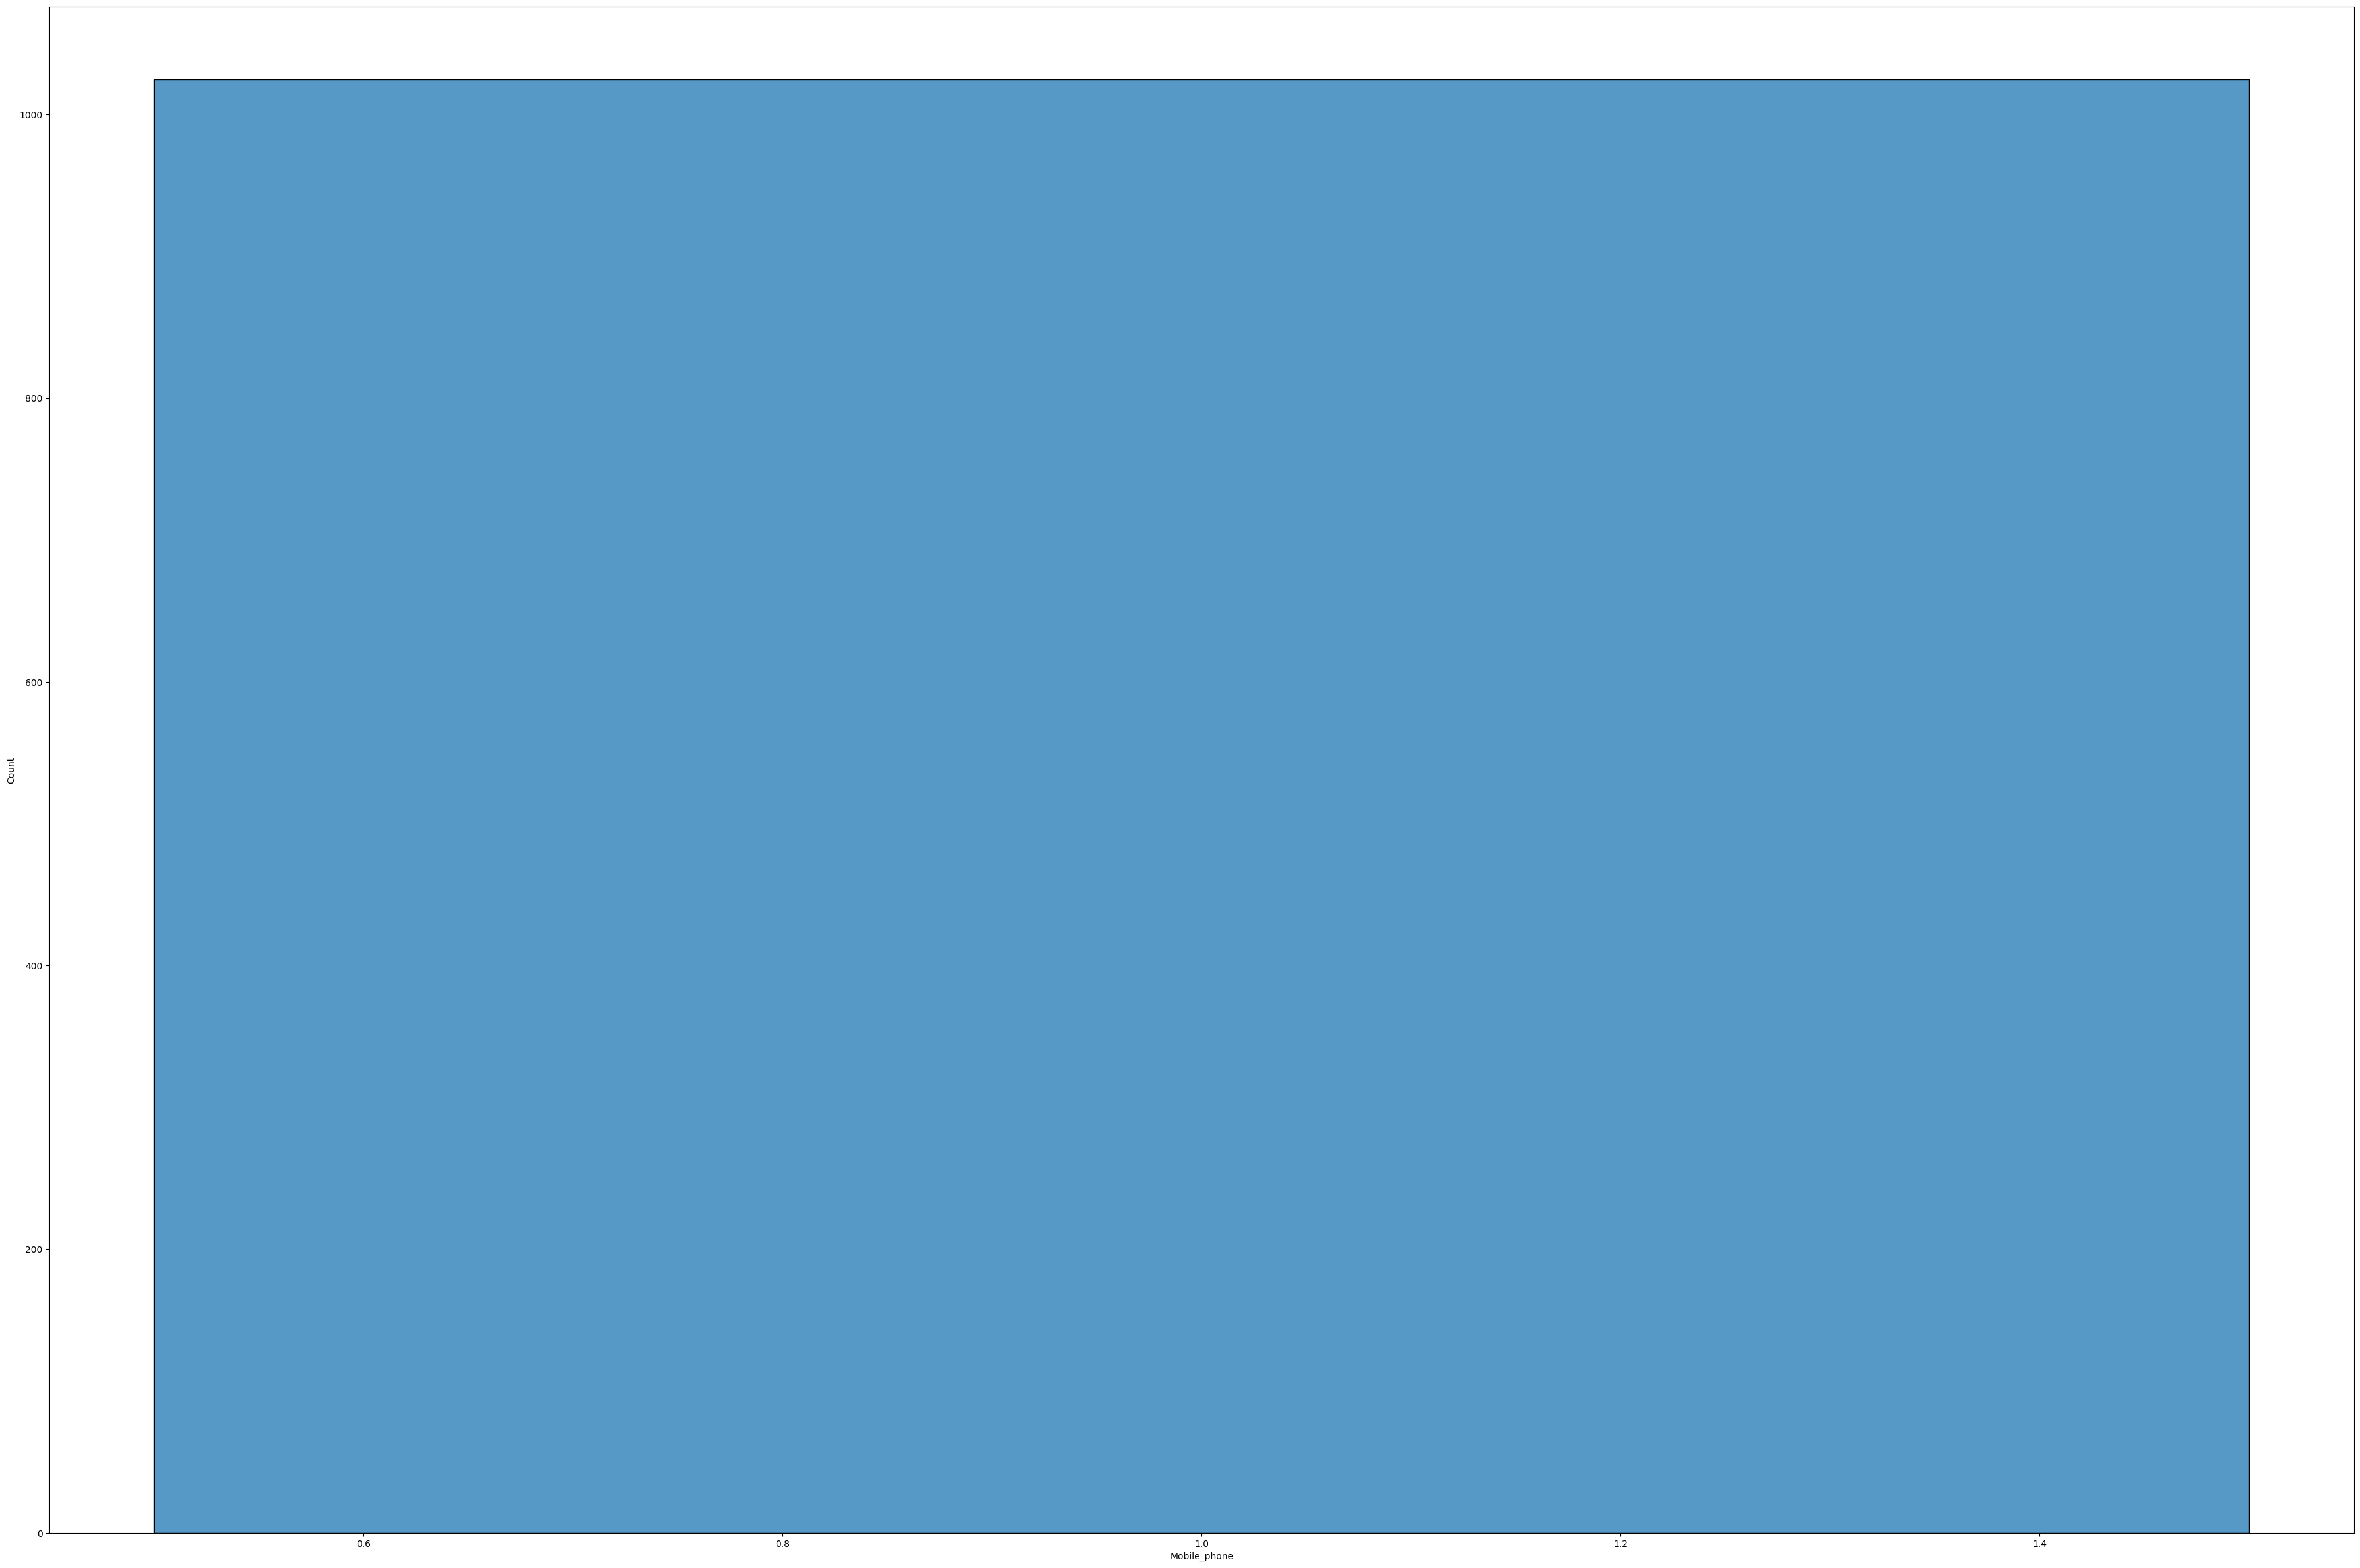

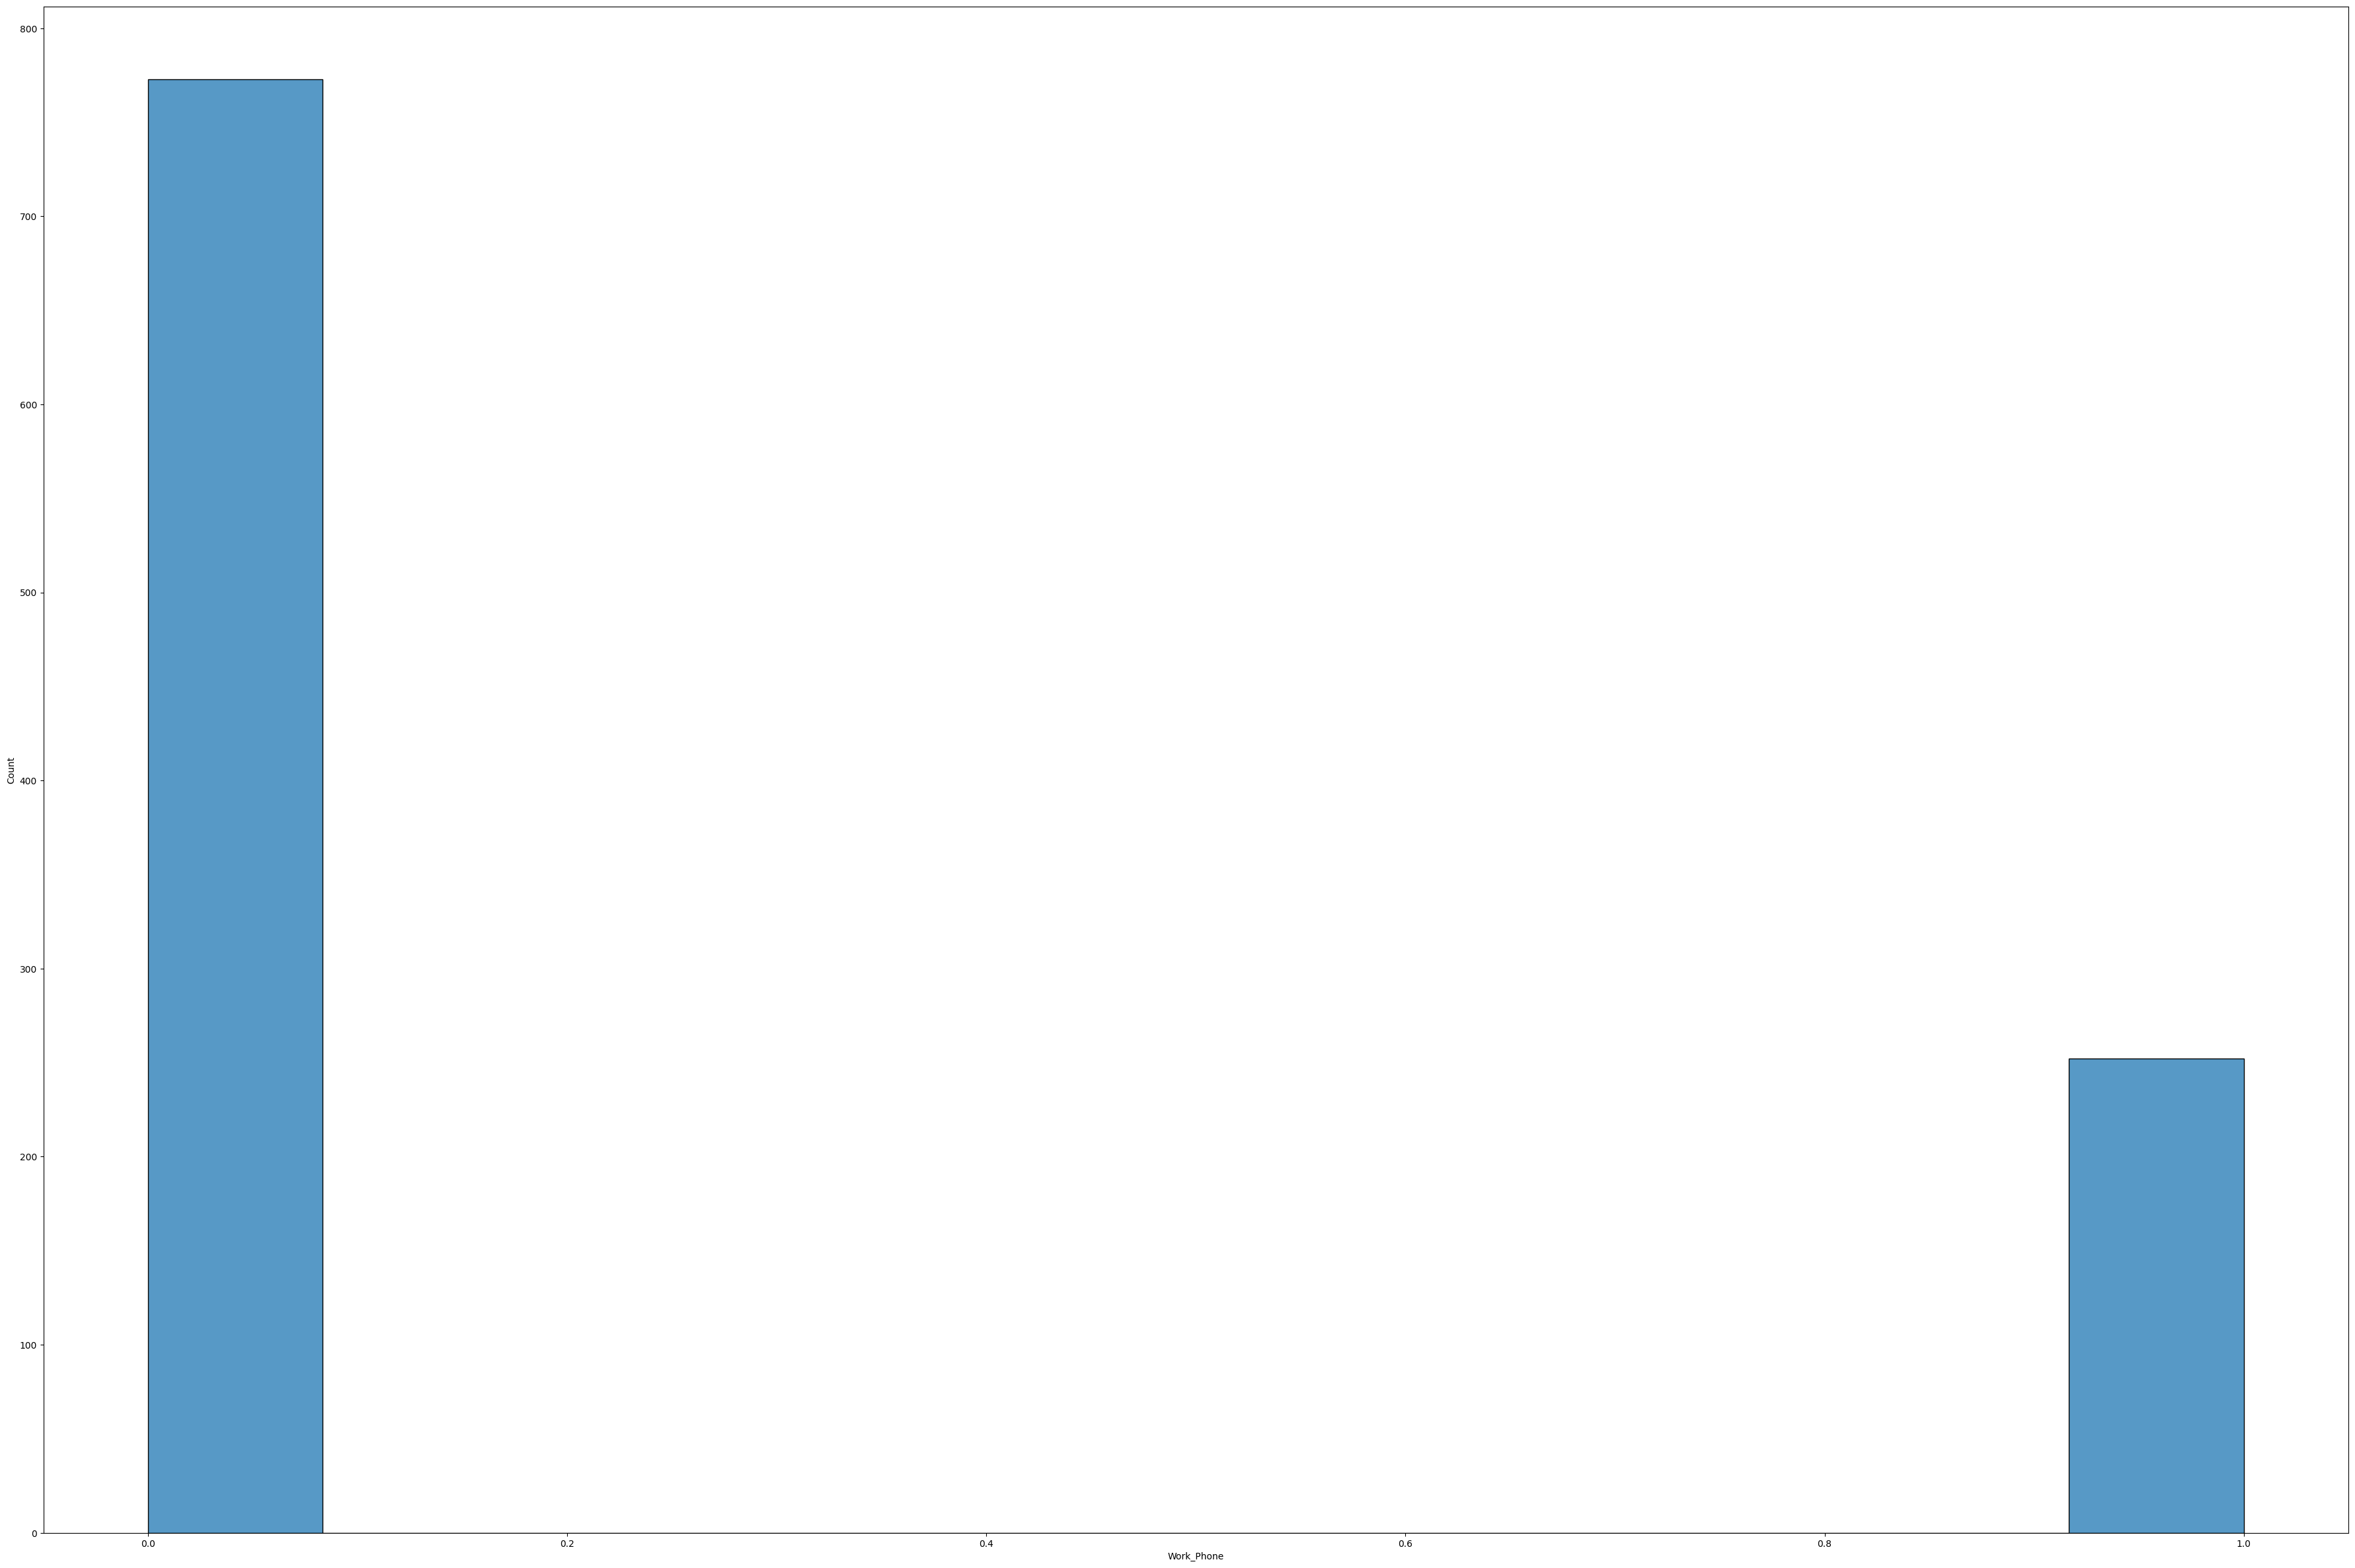

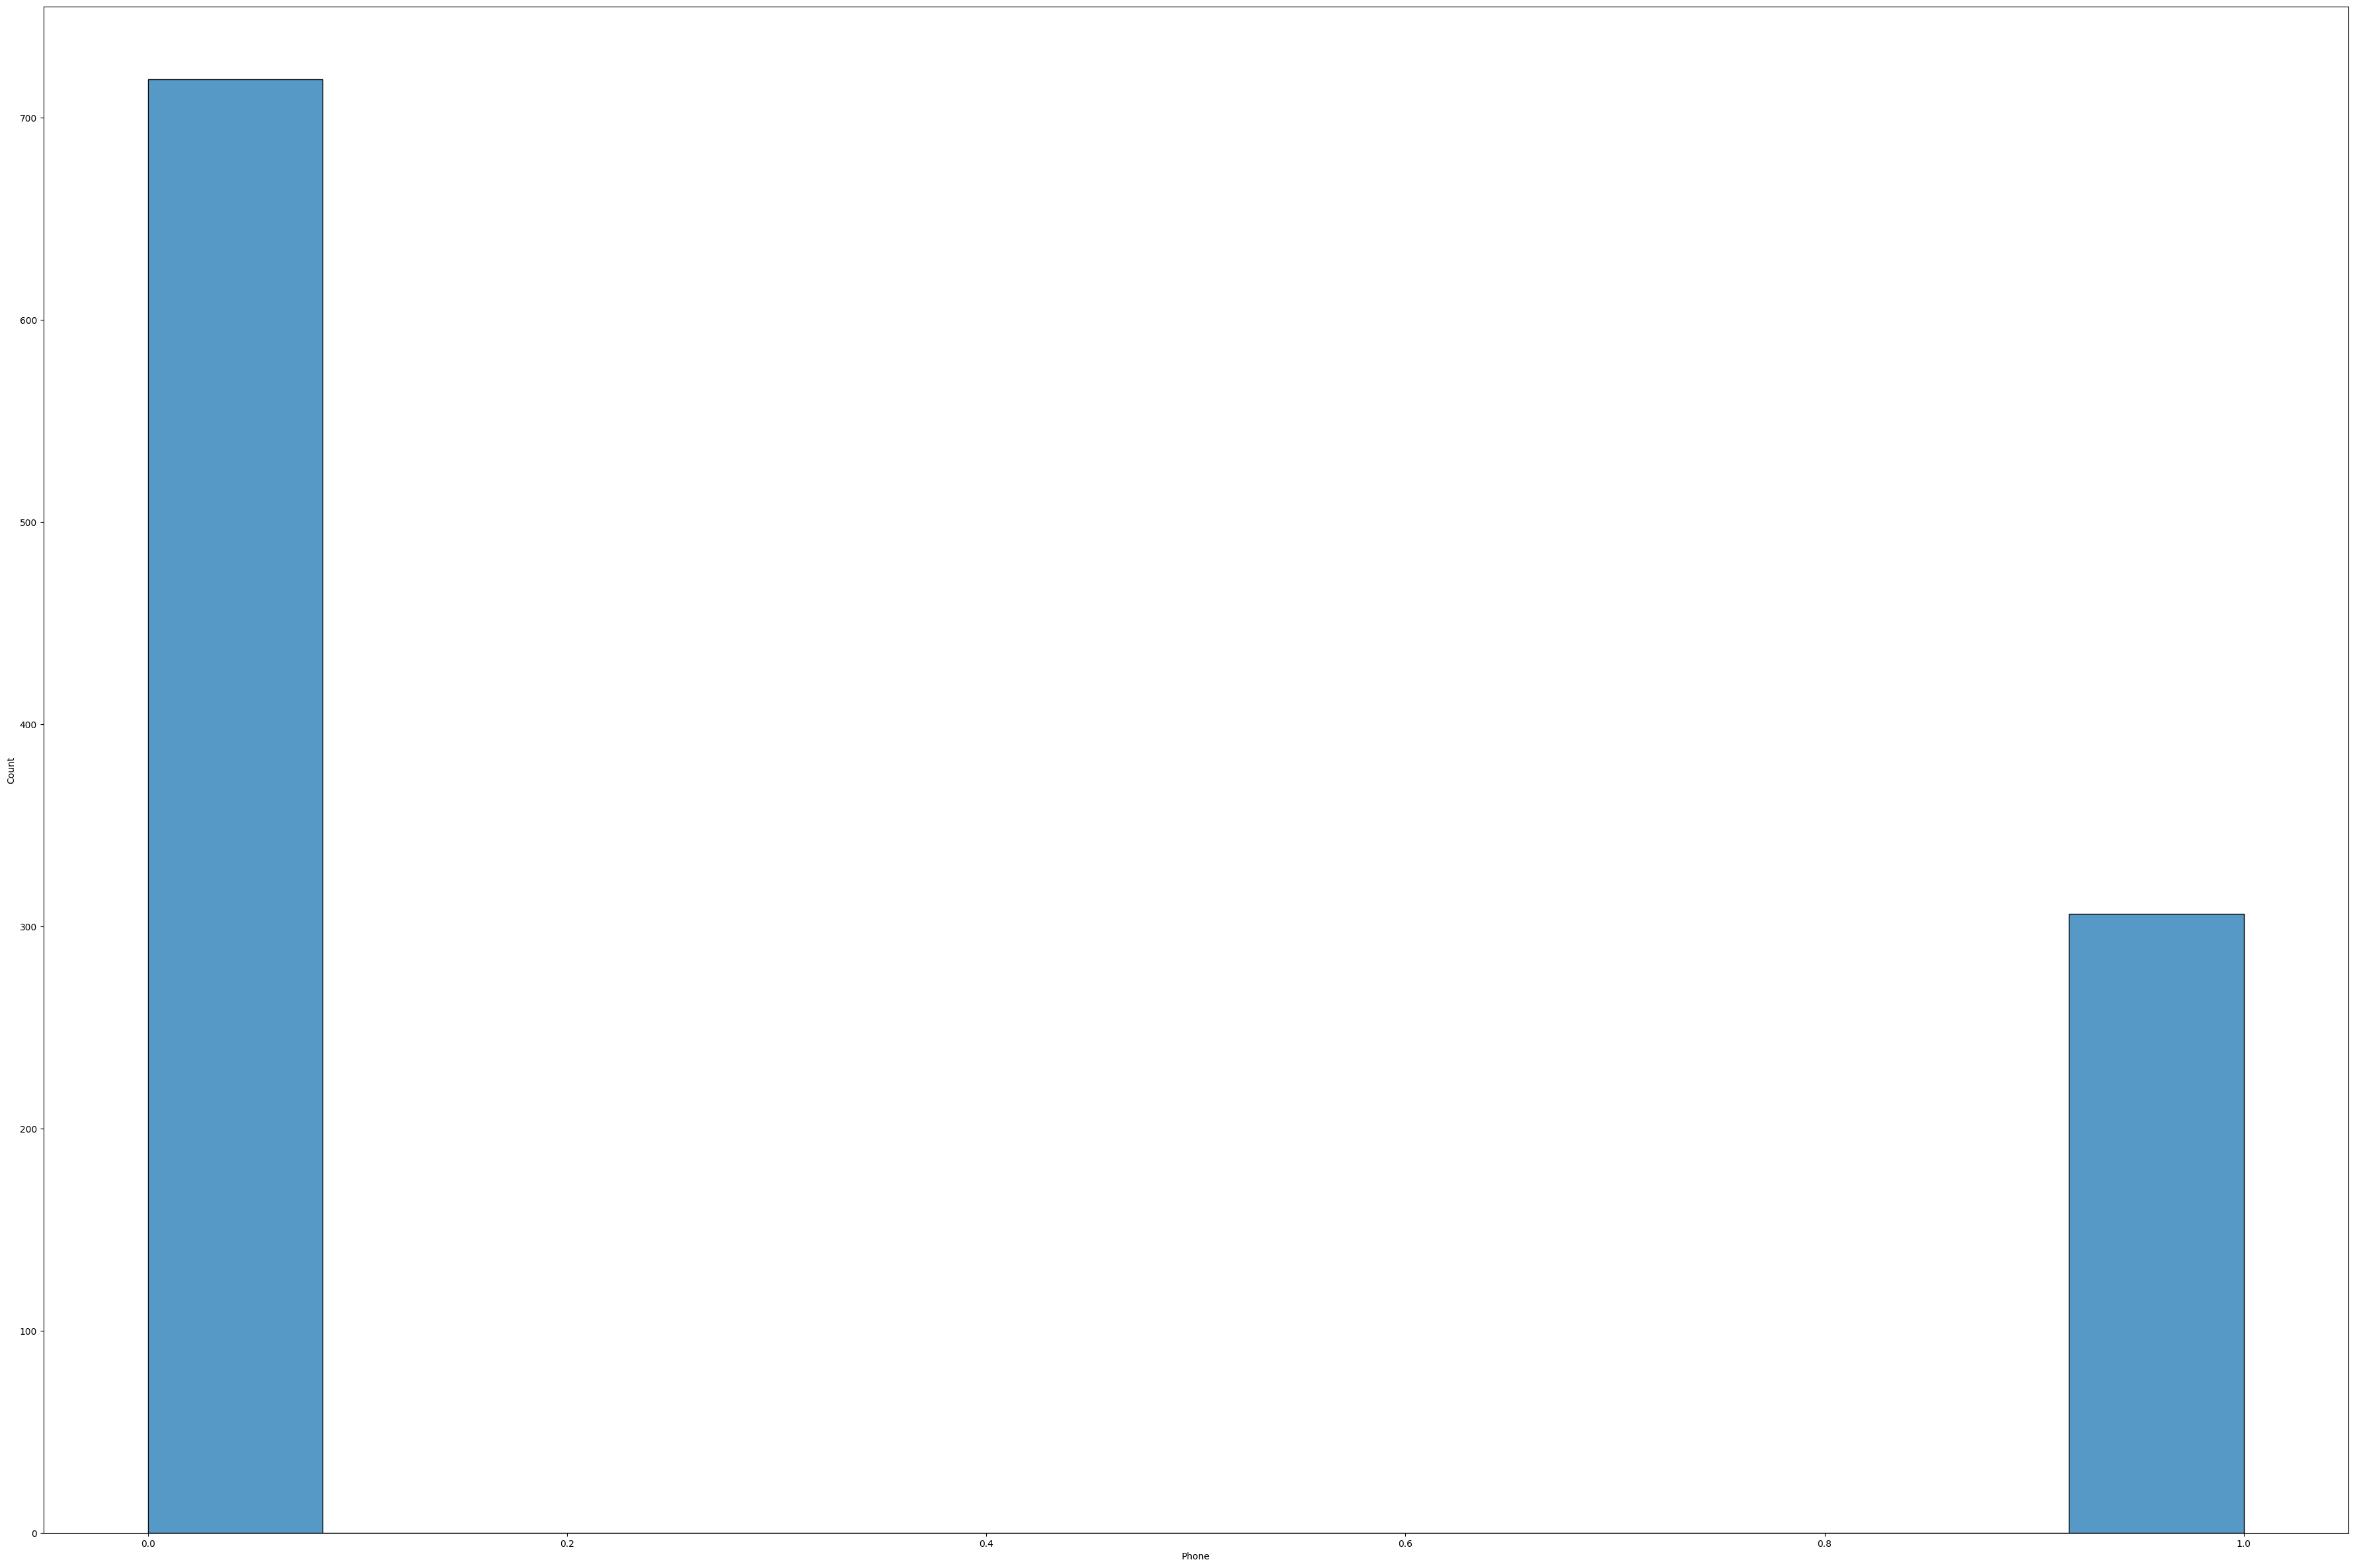

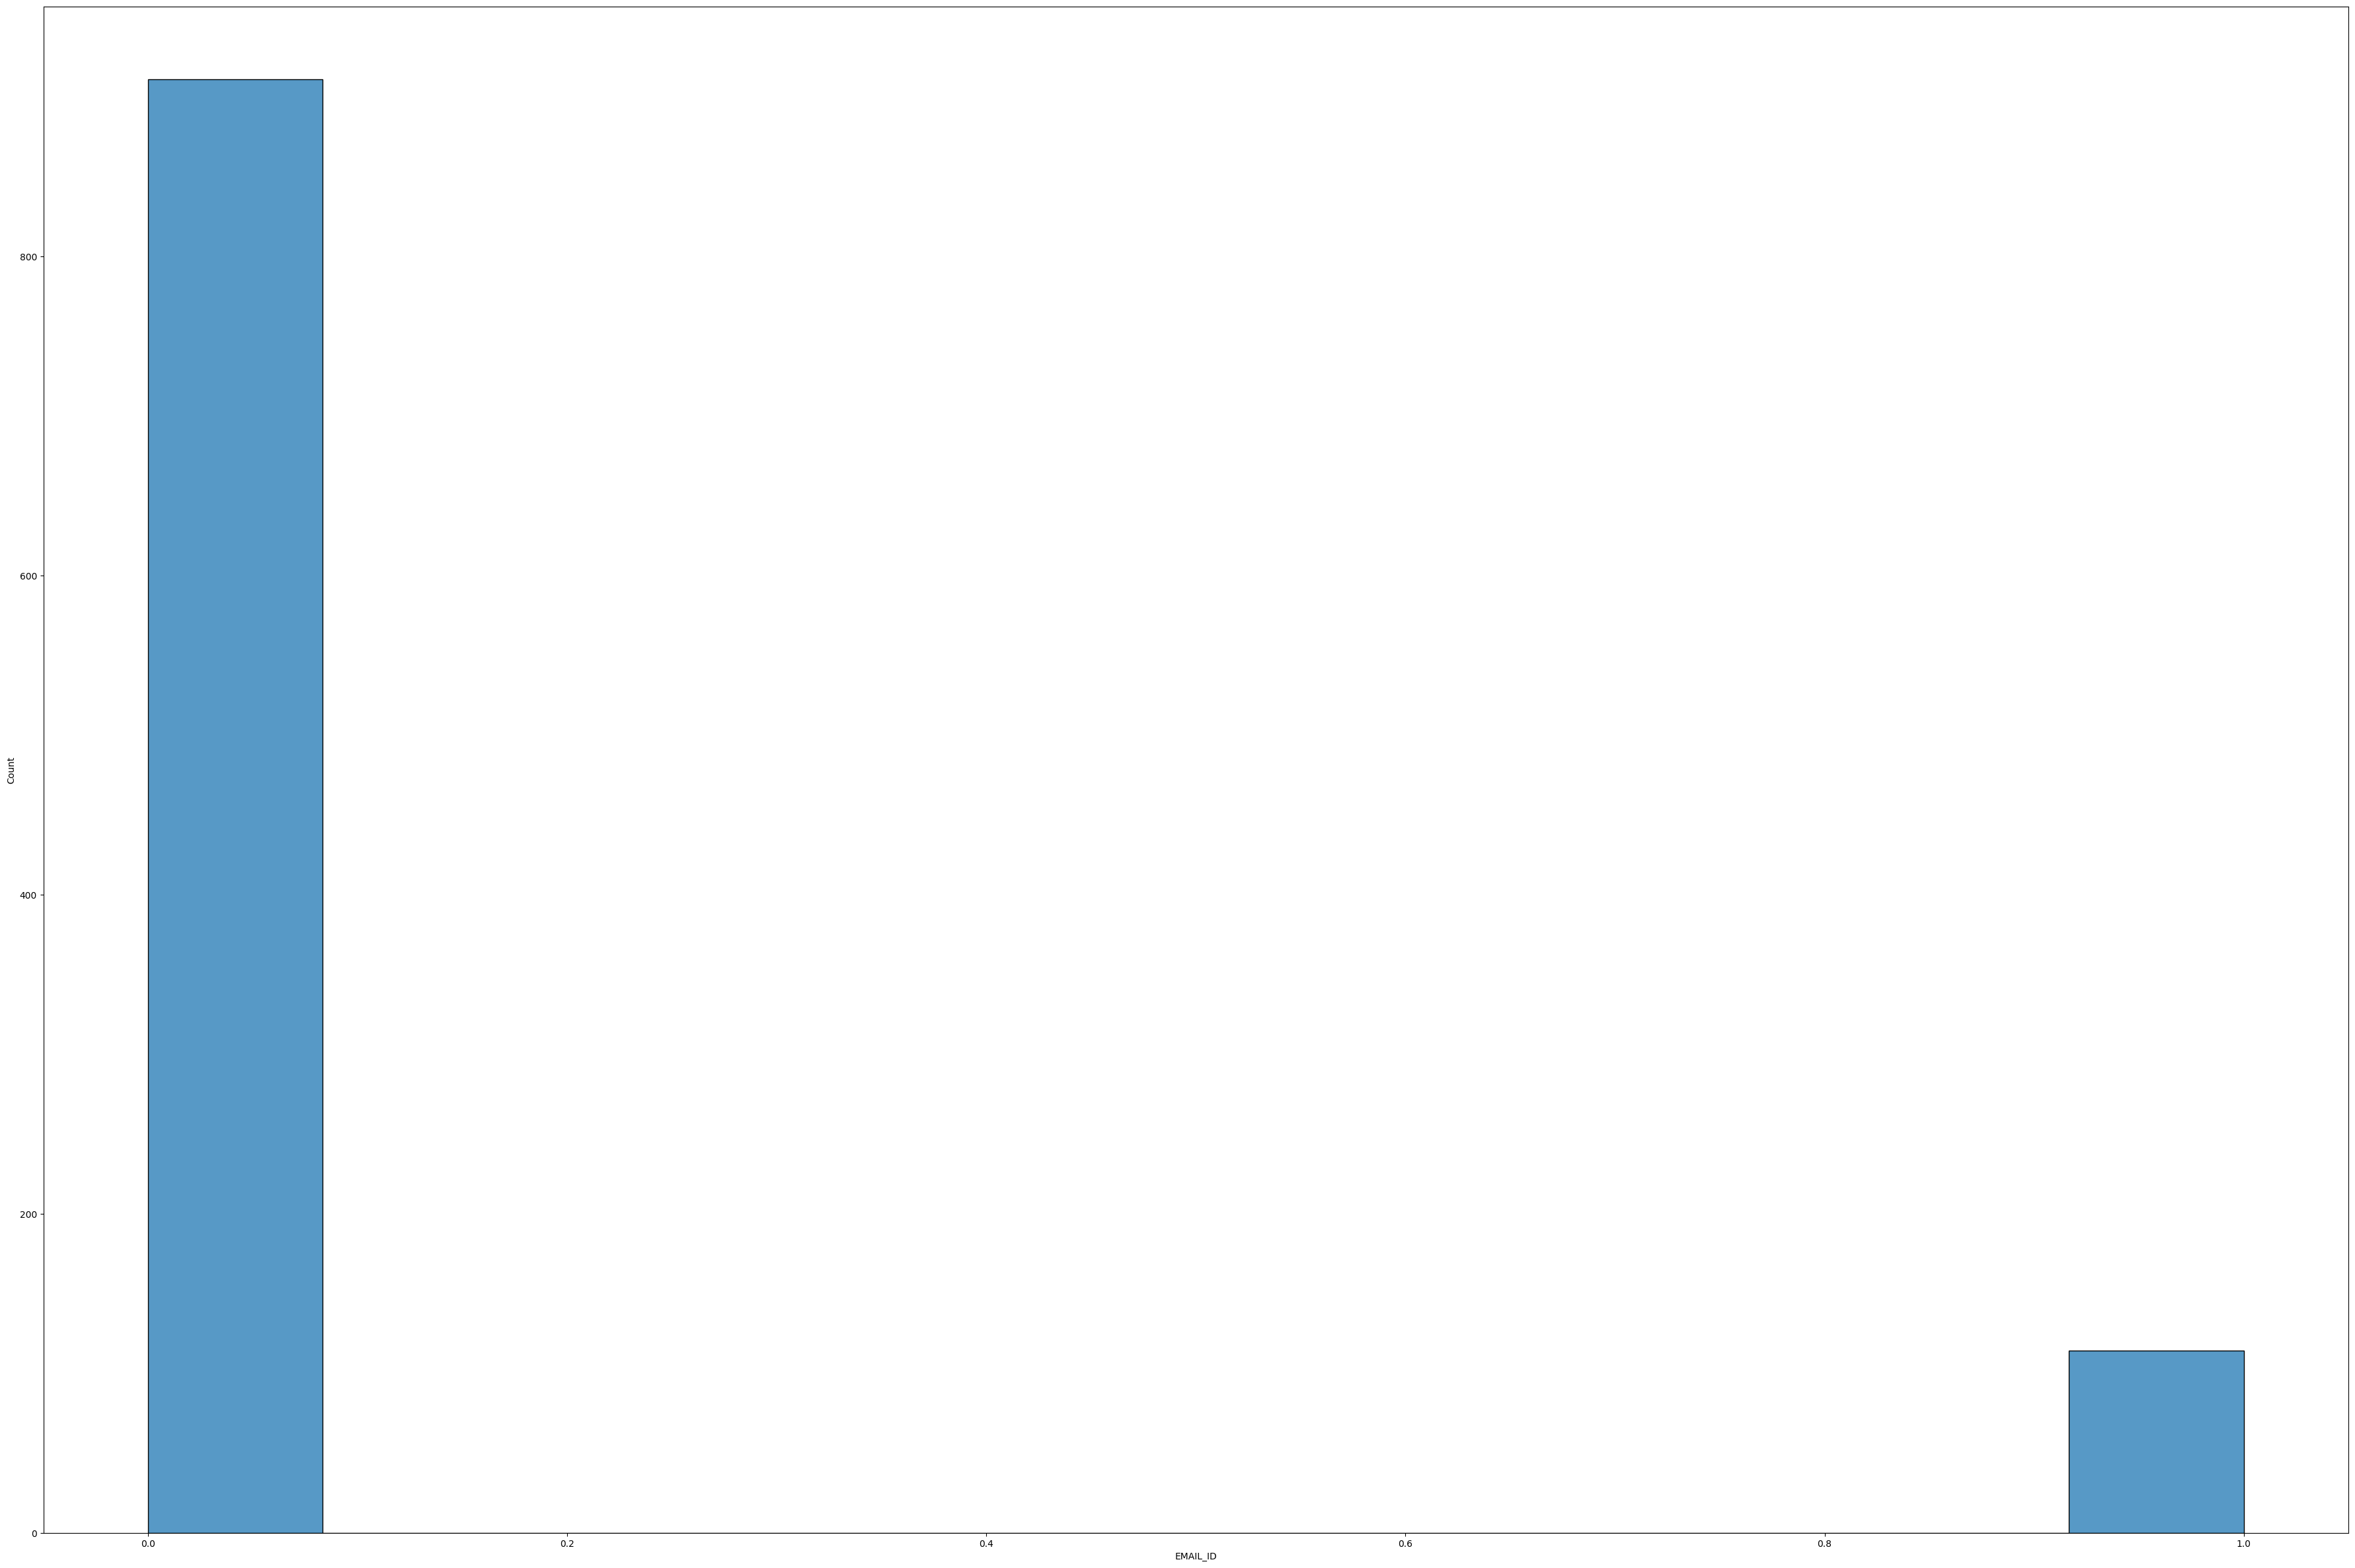

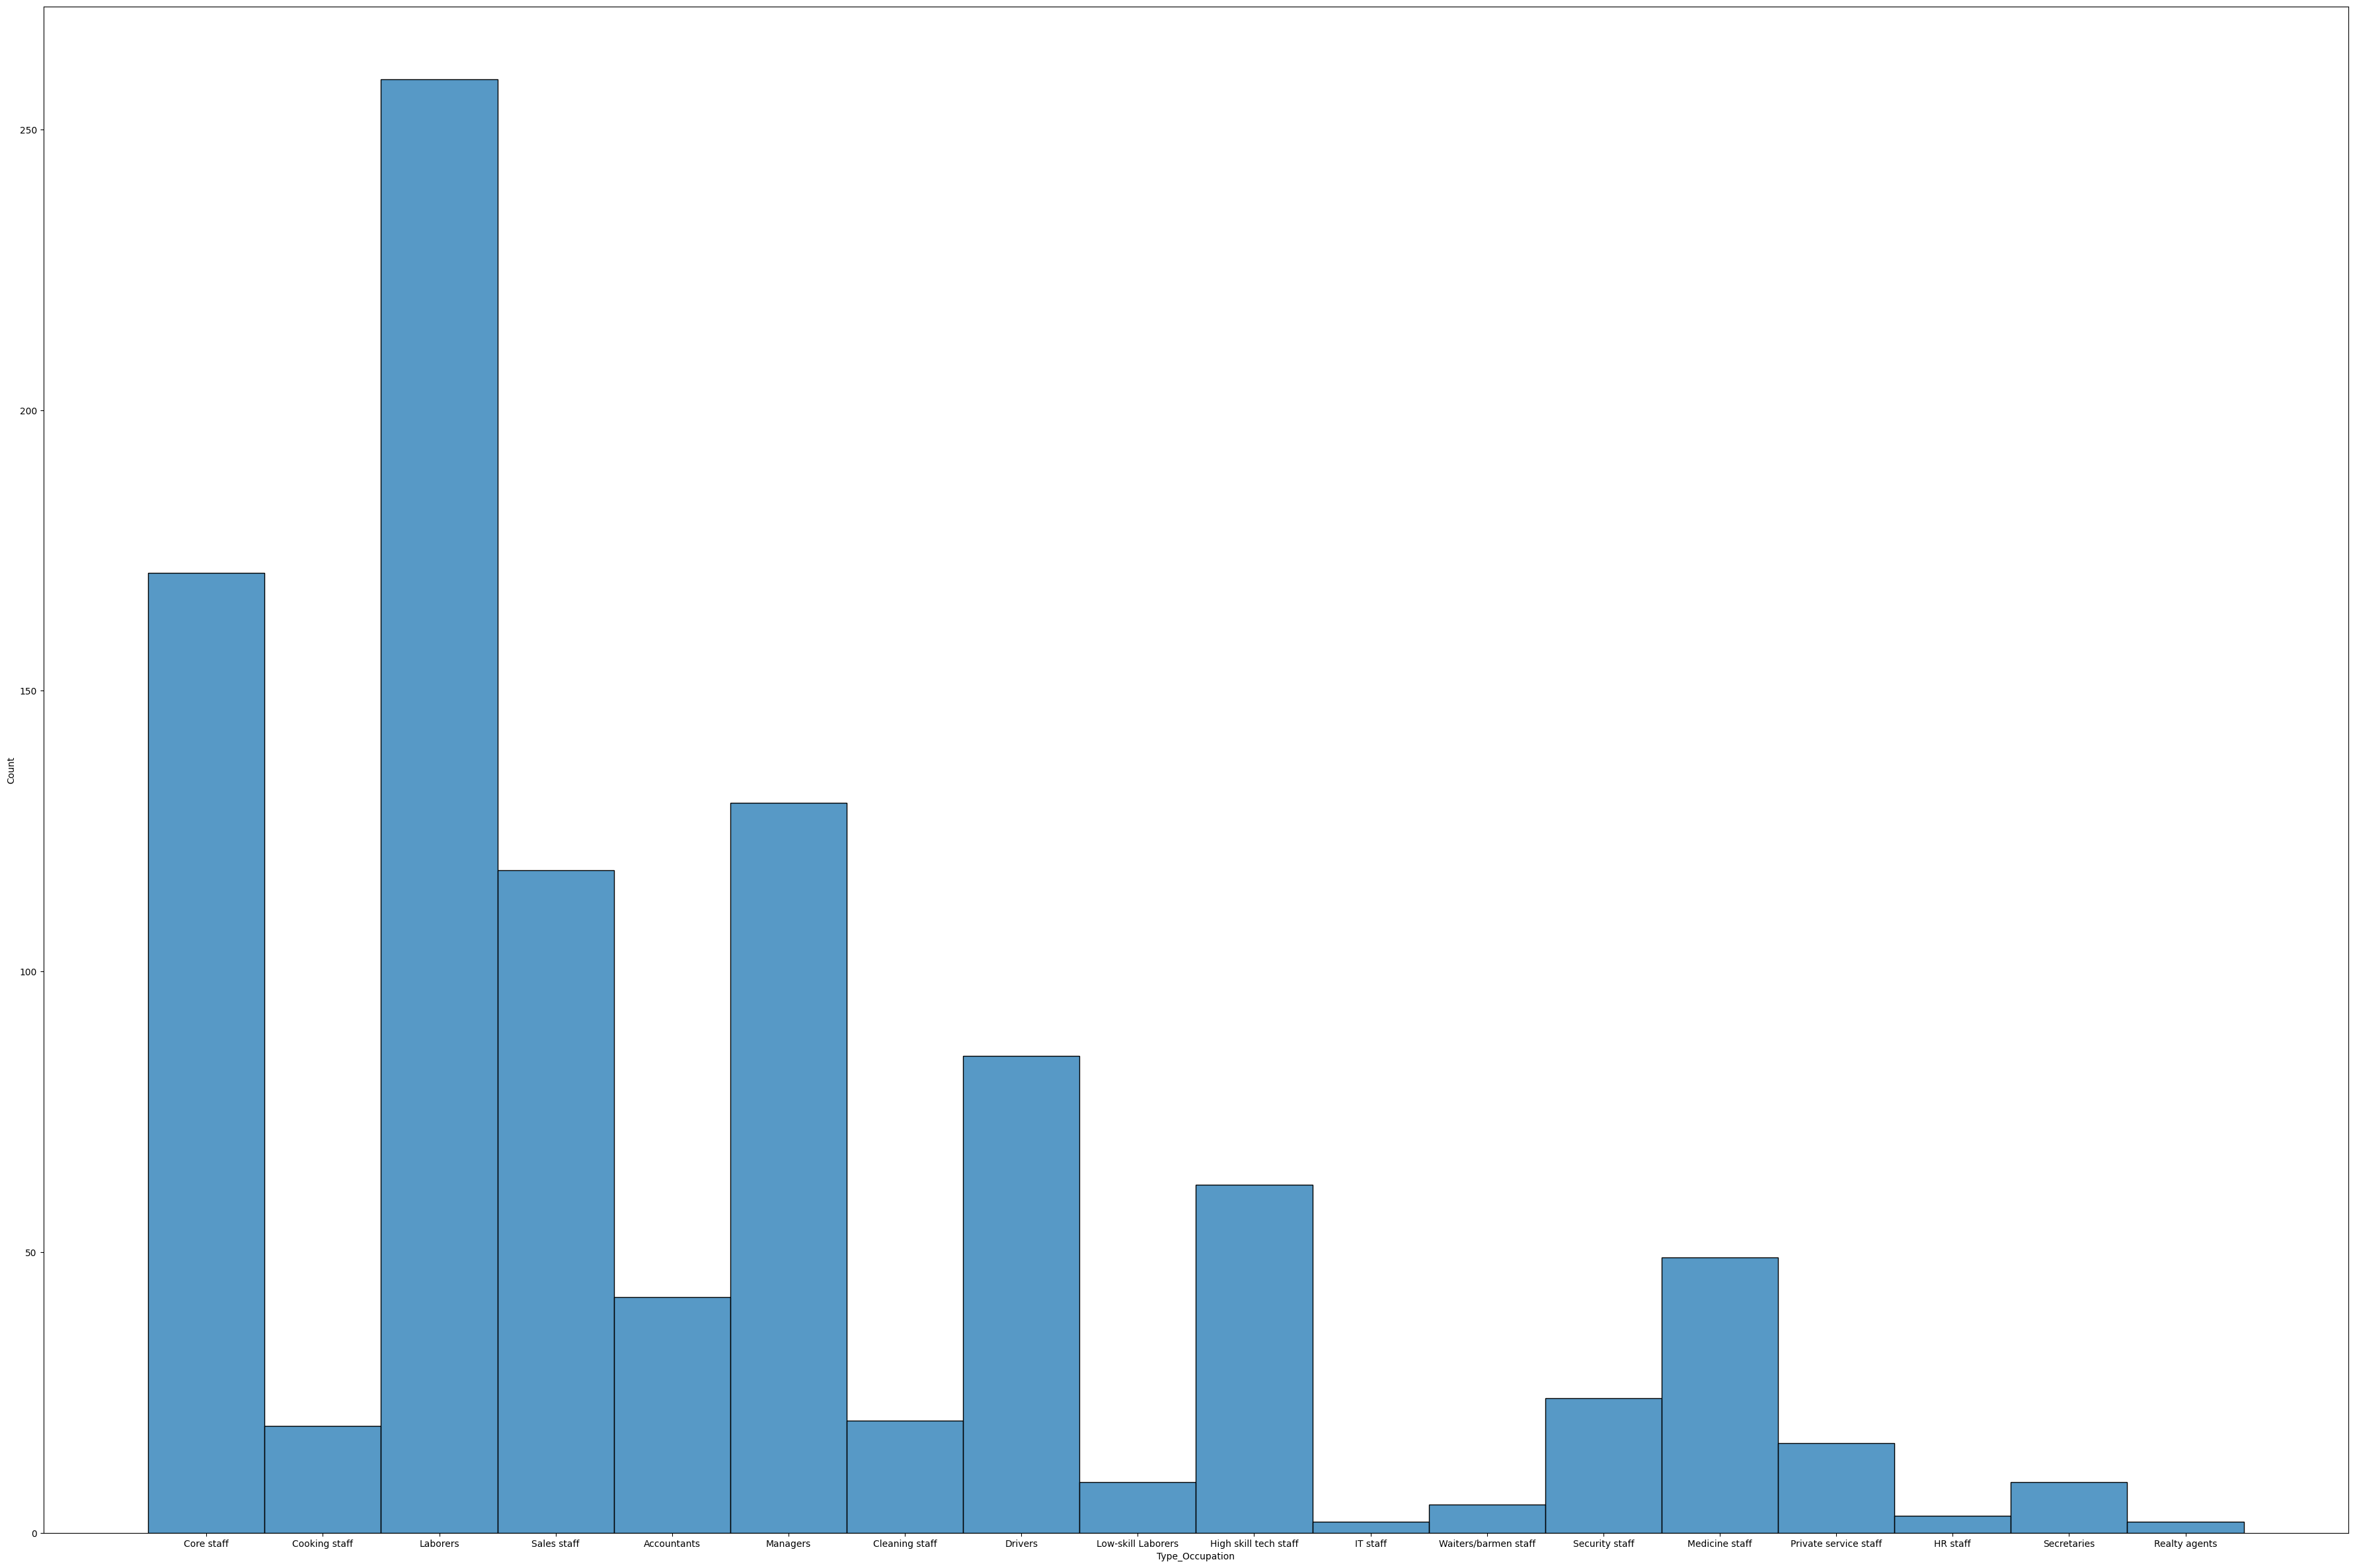

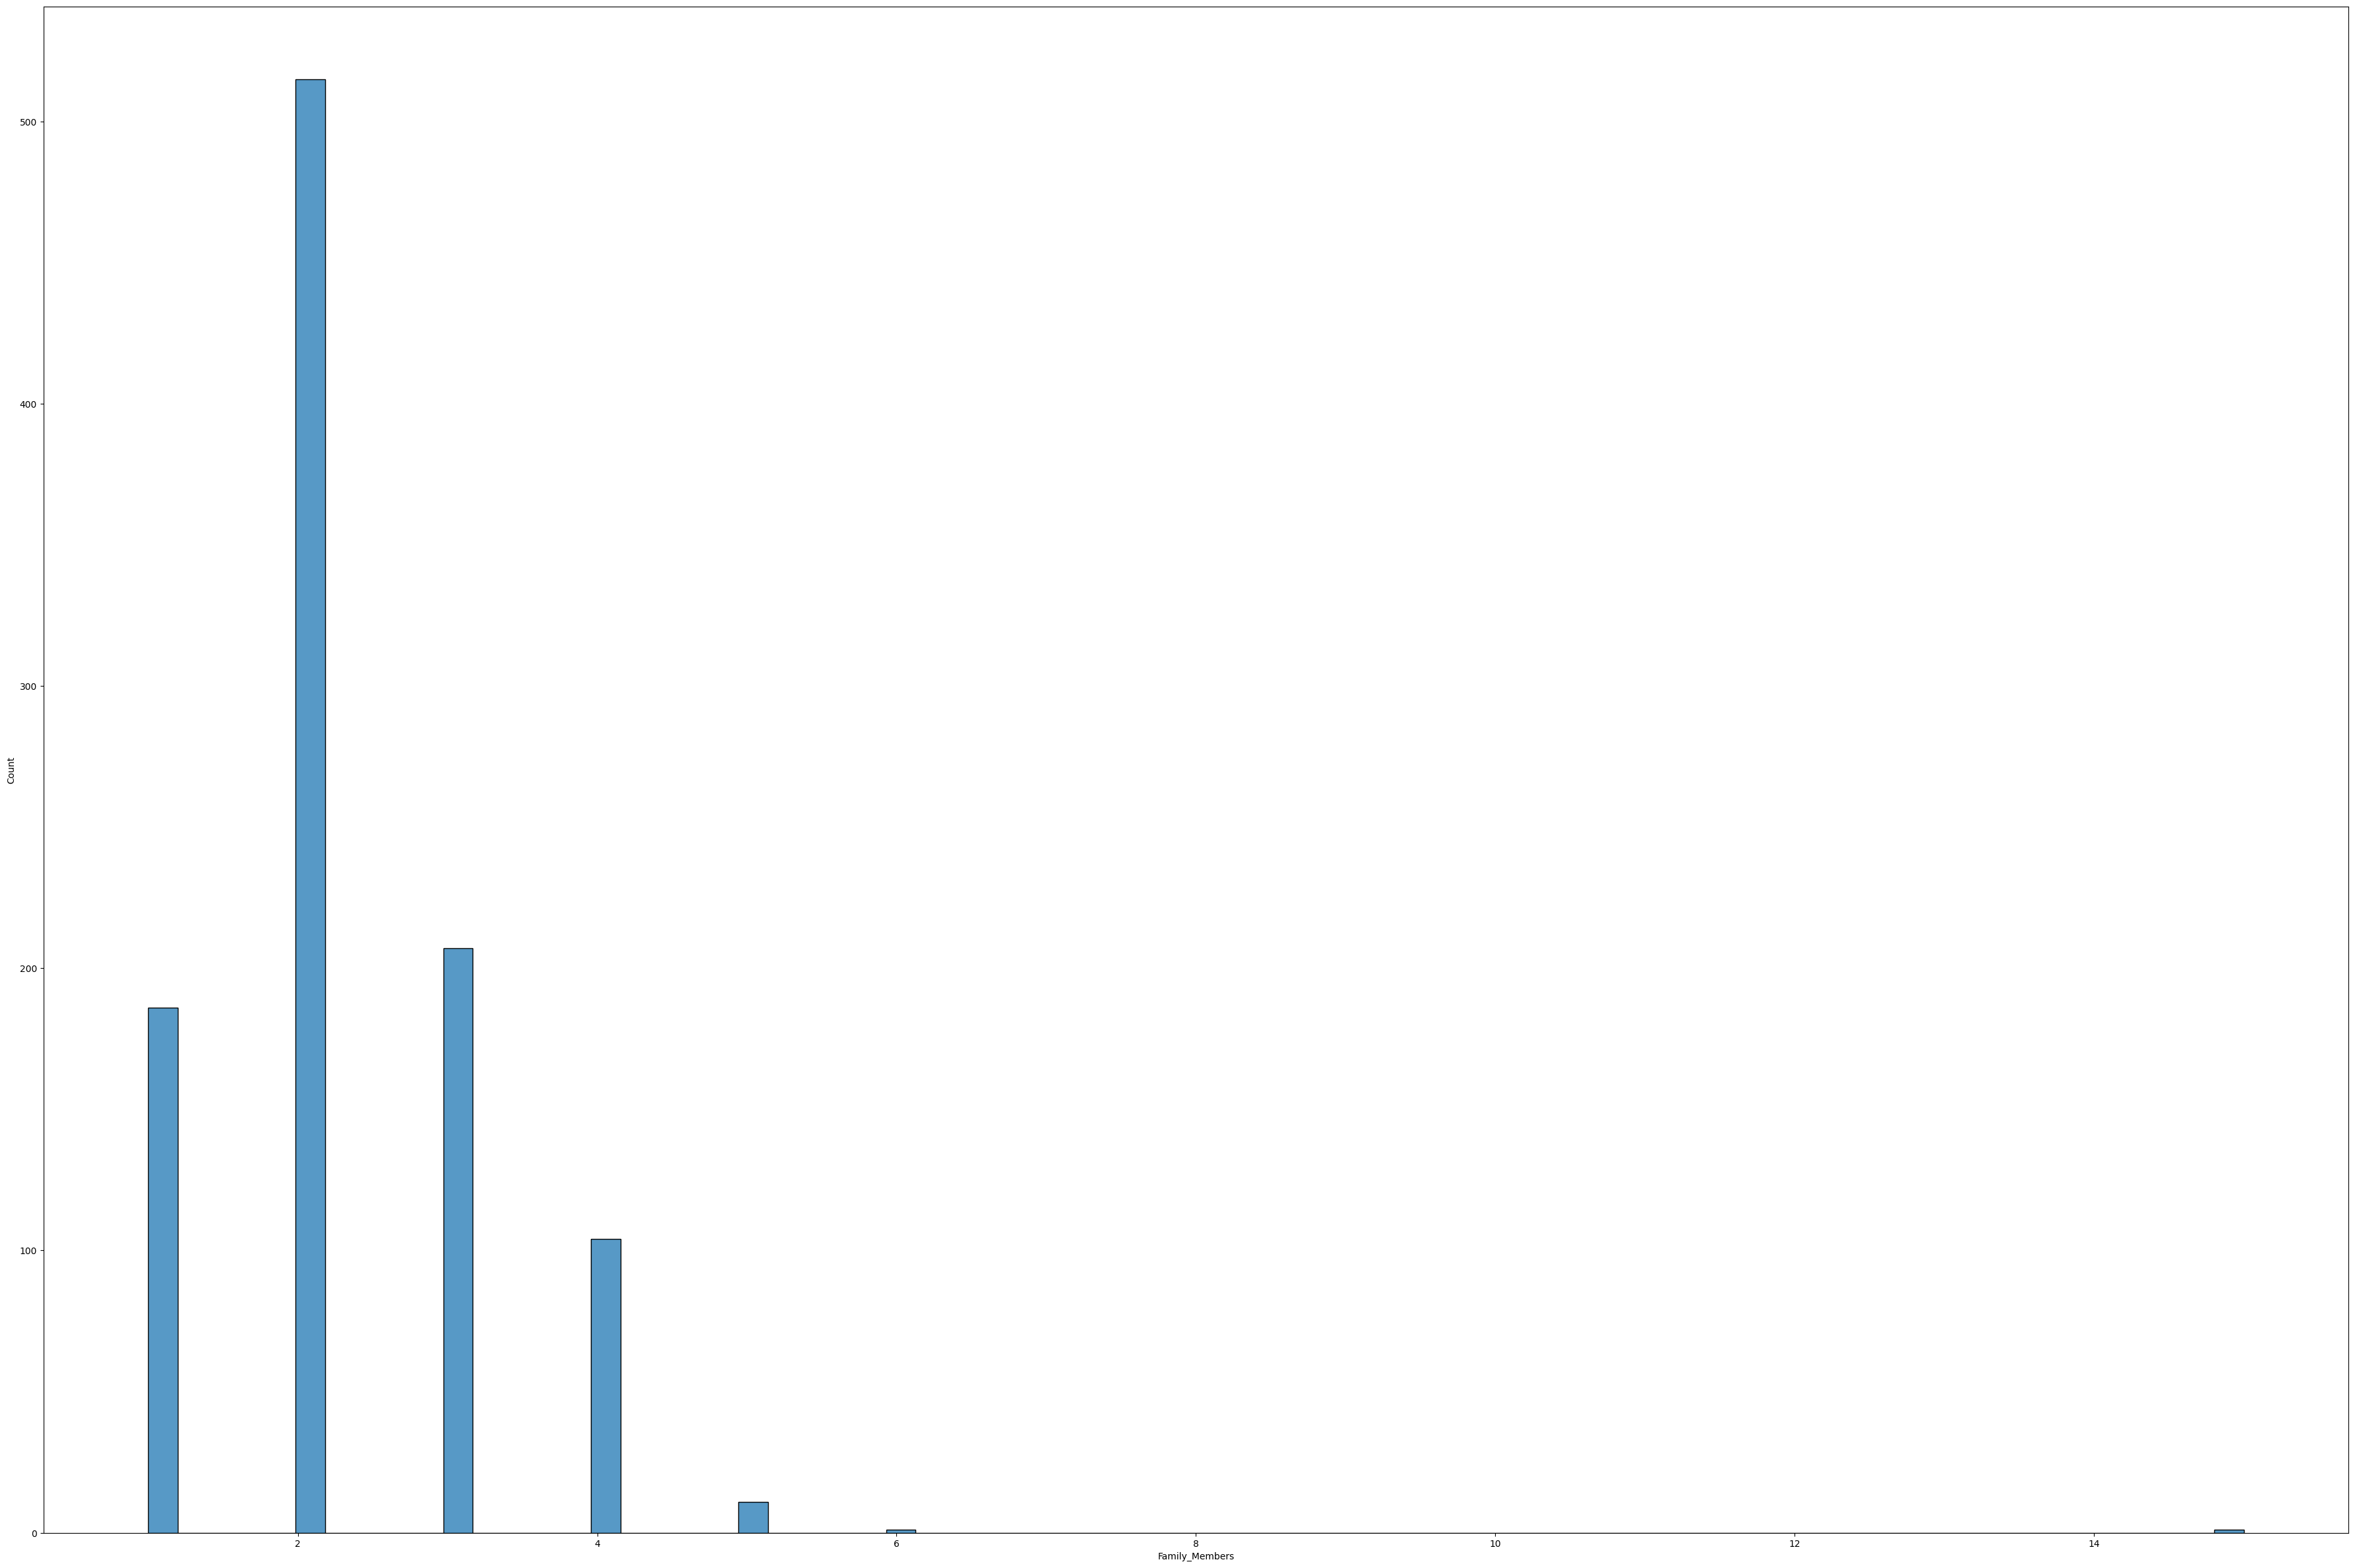

In [14]:
for i in df.columns:
  plt.figure(i,figsize =[45,30] , )
  sns.histplot(data = df, x = i)

<ipython-input-15-e8bc5926f5f2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,robust = True,annot_kws={'size': 20})


<Axes: >

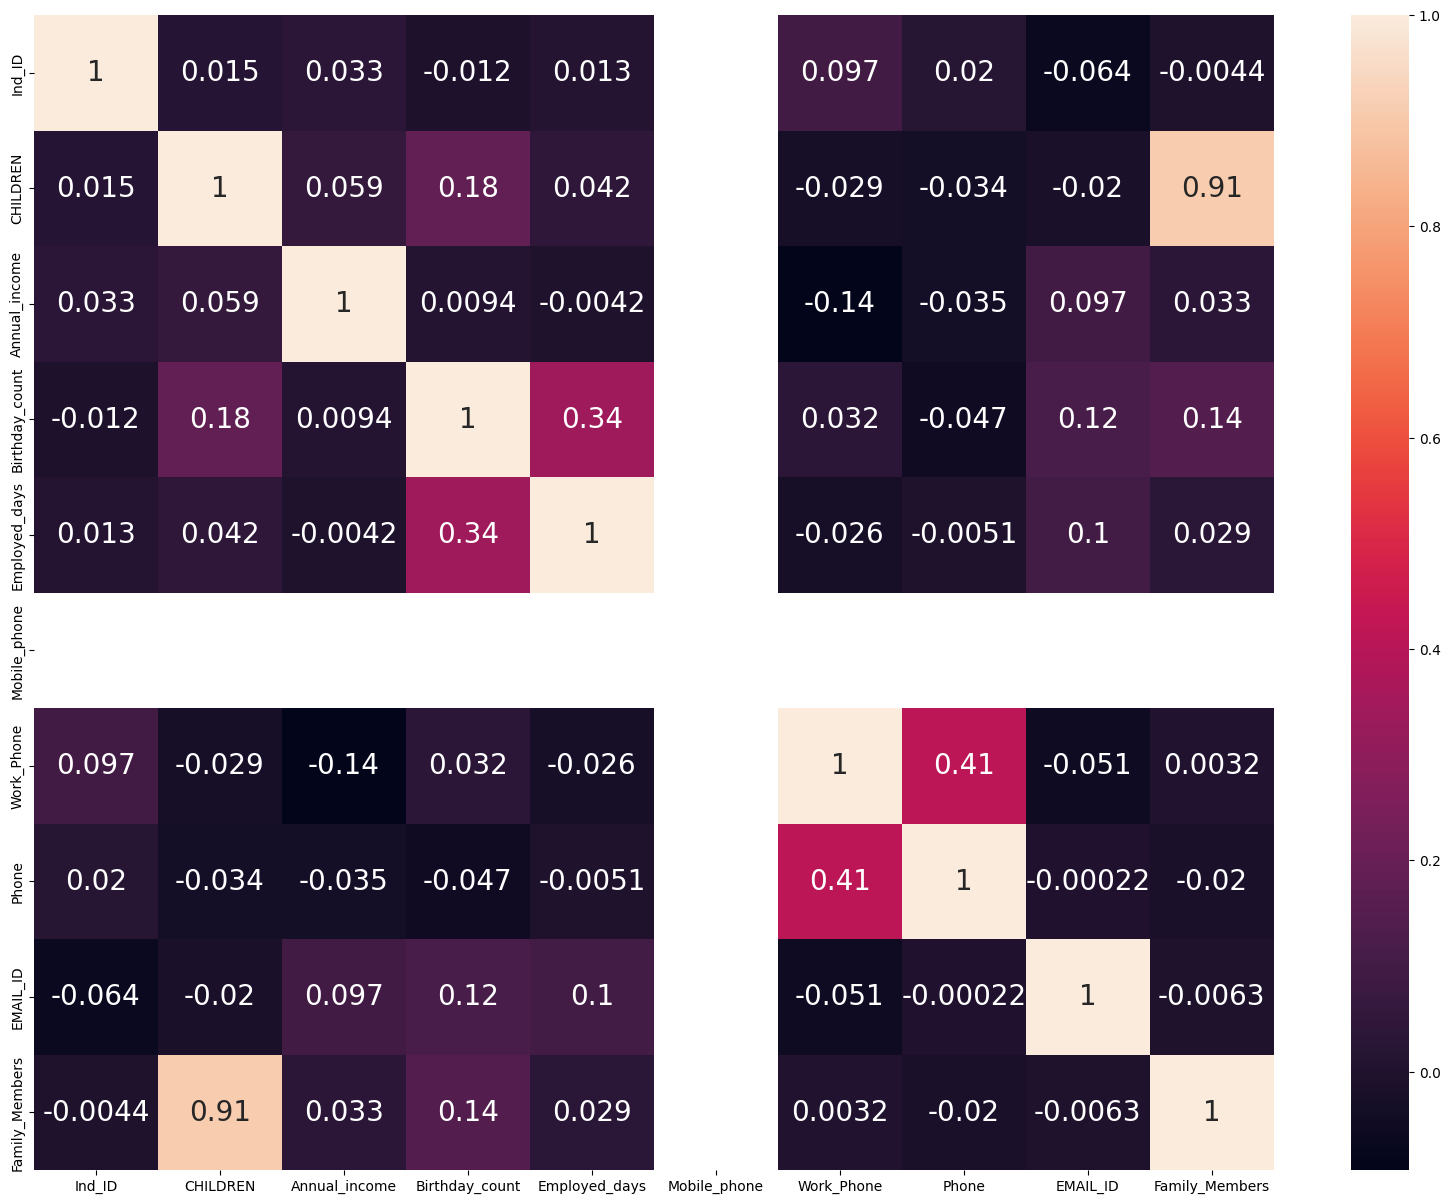

In [15]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(),annot=True,robust = True,annot_kws={'size': 20})

In [16]:
df_with_labels = pd.merge(df_dummies, labels, on='Ind_ID', how='left')
df_with_labels


,Ind_ID,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,...,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff,label
0,5008827,0,180000.0,-18772.0,365243,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,5009744,0,315000.0,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1
2,5009746,0,315000.0,NaN,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1
3,5009749,0,NaN,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1
4,5009752,0,315000.0,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,0,NaN,-11957.0,-2182,1,0,0,0,2,...,0,1,0,0,0,0,0,0,0,0
1544,5023655,0,225000.0,-10229.0,-1209,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1545,5115992,2,180000.0,-13174.0,-2477,1,0,0,0,4,...,0,1,0,0,0,0,0,0,0,0
1546,5118219,0,270000.0,-15292.0,-645,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X = df_with_labels.drop("label",axis = 1)
X

,Ind_ID,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,...,Type_Occupation_Laborers,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff
0,5008827,0,180000.0,-18772.0,365243,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,5009744,0,315000.0,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
2,5009746,0,315000.0,NaN,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
3,5009749,0,NaN,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
4,5009752,0,315000.0,-13557.0,-586,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,0,NaN,-11957.0,-2182,1,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0
1544,5023655,0,225000.0,-10229.0,-1209,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1545,5115992,2,180000.0,-13174.0,-2477,1,0,0,0,4,...,0,0,1,0,0,0,0,0,0,0
1546,5118219,0,270000.0,-15292.0,-645,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0


In [18]:
y = df_with_labels['label']
y

0       1
1       1
2       1
3       1
4       1
       ..
1543    0
1544    0
1545    0
1546    0
1547    0
Name: label, Length: 1548, dtype: int64

In [19]:
model = HistGradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

model.fit(X_train,y_train)


HistGradientBoostingClassifier()

In [20]:
model.score(X_test,y_test)

0.9432485322896281

In [21]:
y_pred = model.predict(X_test)

In [22]:
confusion_matrix(y_test,y_pred)

array([[461,   3],
       [ 26,  21]])